# ETL for the Snow Emergency Tags Data Sets
The .CSV files for the Snow Emergency data sets differ between snow emergencies.  Columns have differing names, different columns are included in different files, community and neighborhood names are not standard, dates and times are in different formats, etc.  For each file, we will  transform each file to have the following columns:

Date, Time, Location, Latitude, Longitude, Day, Ward, Community, Neighborhood, Emergency.

To achieve this, we will need to:
1.  Rename columns to have uniform names.
2.  Drop extra columns.
3.  Pick a uniform date and time format and split the datetime string into a date and time field.
4.  Pick uniform neighborhood and community names.  The easiest way to do this is to use the City of Minneapolis OpenData GeoJSON files of communities and neighborhoods for uniform names.
5.  Write the final data frame to a `.csv` file to be combined with the other cleaned files.

In [1]:
# import the dependencies
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import geopy

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# constants related to input and output

DATA_DIR = "data"
OUTPUT_DIR = "output"
WARDS_FILE = "City_Council_Wards.geojson"
COMMUNITIES_FILE = "Communities.geojson"
NEIGHBORHOODS_FILE = "Minneapolis_Neighborhoods.geojson"

In [3]:
import re

input_files = os.listdir(DATA_DIR)

substring_pattern = r'Tags.*csv'
tags_files = [file_name for file_name in input_files if re.search(substring_pattern, file_name)]
tags_files

['Snow_Emergency_Armatage_Tags_2019.csv',
 'Snow_Emergency_Dana_Tags_2016.csv',
 'Snow_Emergency_Diamond_Lake_Tags_2019.csv',
 'Snow_Emergency_Ferry_Tags_2016.csv',
 'Snow_Emergency_Grant_Tags_2015.csv',
 'Snow_Emergency_Howe_Tags_2018.csv',
 'Snow_Emergency_Jane_Tags_2017.csv',
 'Snow_Emergency_Olive_Tags_2018.csv',
 'Snow_Emergency_Pembina_Tags_2018.csv',
 'Snow_Emergency_Polk_Tags_2016.csv',
 'Snow_Emergency_Quincy_Tags_2019.csv',
 'Snow_Emergency_Upton_Tags_2019.csv',
 'Snow_Emergency_Westminster_Tags_2019.csv',
 'Snow_Emergency_Xerxes_Tags_2018.csv',
 'Snow_Emergency_Yale_Tags_2019.csv',
 'Snow_Emergency_Yardville_Tags_2018.csv']

In [4]:
TAGS_FILES = {file_name.split('_')[2]: file_name for file_name in tags_files}
TAGS_FILES

{'Armatage': 'Snow_Emergency_Armatage_Tags_2019.csv',
 'Dana': 'Snow_Emergency_Dana_Tags_2016.csv',
 'Diamond': 'Snow_Emergency_Diamond_Lake_Tags_2019.csv',
 'Ferry': 'Snow_Emergency_Ferry_Tags_2016.csv',
 'Grant': 'Snow_Emergency_Grant_Tags_2015.csv',
 'Howe': 'Snow_Emergency_Howe_Tags_2018.csv',
 'Jane': 'Snow_Emergency_Jane_Tags_2017.csv',
 'Olive': 'Snow_Emergency_Olive_Tags_2018.csv',
 'Pembina': 'Snow_Emergency_Pembina_Tags_2018.csv',
 'Polk': 'Snow_Emergency_Polk_Tags_2016.csv',
 'Quincy': 'Snow_Emergency_Quincy_Tags_2019.csv',
 'Upton': 'Snow_Emergency_Upton_Tags_2019.csv',
 'Westminster': 'Snow_Emergency_Westminster_Tags_2019.csv',
 'Xerxes': 'Snow_Emergency_Xerxes_Tags_2018.csv',
 'Yale': 'Snow_Emergency_Yale_Tags_2019.csv',
 'Yardville': 'Snow_Emergency_Yardville_Tags_2018.csv'}

In [5]:
# a helper function to read GeoJSON files in.  GeoPandas read_file can load GeoJSONs

def load_geojson(filename, data_dir=DATA_DIR):
    filepath = os.path.join(data_dir, filename)
    return gpd.read_file(filepath)

def load_csv(filename, data_dir=DATA_DIR):
    filepath = os.path.join(data_dir, filename)
    return pd.read_csv(filepath)

In [6]:
# Look at the first rows of each input data file to see what needs to be adjusted in each case:

def peek_columns(input_files_dict=TAGS_FILES, data_dir=DATA_DIR):
    for key,value in input_files_dict.items():
        tmp = load_csv(value, data_dir)
        print(key + ": ")
        print(tmp.head(1))

In [7]:
peek_columns()

Armatage: 
           X          Y  OBJECTID    Citation_N                      Date  \
0 -93.290601  45.015587      5001  271119358297  2019-02-26T00:00:00.000Z   

        Address    Ordinance  \
0  BRYANT AVE N  478.1000(c)   

                                          Ordinanc_1   Latitude  Longitude  \
0  Snow emergency parking restrictions - odd numb...  45.015587 -93.290601   

   Ward Neighborho Community  Tow_Zone  Day Snow_Emerg  
0     4   McKinley    Camden         1    3   Armatage  
Dana: 
           X          Y   FID  Citation_N                      Date  \
0 -93.267575  44.963906  7001   533616352  2016-12-13T00:00:00.000Z   

         Address  X_Coordina  Y_Coordina    Ordinance          Ordinanc_1  \
0  601 19TH ST E   -10382499     5615841  478.1000(C)  SNOW EMERGENCY ODD   

   Ward       Neighborho Community  Day_ID  TowDist F13 F14  
0     6  Ventura Village  Phillips       3        3          
Diamond: 
           X          Y  OBJECTID    Citation_N            

# Armatage ETL

In [28]:
armatage = load_csv(TAGS_FILES['Armatage'])
armatage.head()

,X,Y,OBJECTID,Citation_N,Date,Address,Ordinance,Ordinanc_1,Latitude,Longitude,Ward,Neighborho,Community,Tow_Zone,Day,Snow_Emerg
0,-93.290601,45.015587,5001,271119358297,2019-02-26T00:00:00.000Z,BRYANT AVE N,478.1000(c),Snow emergency parking restrictions - odd numb...,45.015587,-93.290601,4,McKinley,Camden,1,3,Armatage
1,-93.307014,45.016145,5002,271119356335,2019-02-26T00:00:00.000Z,OLIVER AVE N,478.1000(c),Snow emergency parking restrictions - odd numb...,45.016145,-93.307014,4,Folwell,Camden,1,3,Armatage
2,-93.292821,44.959333,5003,271119355001,2019-02-26T00:00:00.000Z,DUPONT AVE S,478.1000(c),Snow emergency parking restrictions - odd numb...,44.959333,-93.292821,10,Lowry Hill East,Calhoun Isle,3,3,Armatage
3,-93.293048,44.956760,5004,271119358701,2019-02-26T00:00:00.000Z,DUPONT AVE S,478.1000(c),Snow emergency parking restrictions - odd numb...,44.956760,-93.293048,10,Lowry Hill East,Calhoun Isle,3,3,Armatage
4,-93.290589,45.015412,5005,271119358298,2019-02-26T00:00:00.000Z,BRYANT AVE N,478.1000(c),Snow emergency parking restrictions - odd numb...,45.015412,-93.290589,4,McKinley,Camden,1,3,Armatage


In [29]:
armatage.rename(columns={'Neighborho': 'Neighborhood', 'Snow_Emerg': 'Emergency',\
                         'Address': 'Location', 'Date': 'Datetime'}, inplace=True)

In [30]:
import dateutil.parser as dparser
from datetime import datetime

test = dparser.parse(armatage.loc[0, 'Datetime'], fuzzy=True)
print(test.strftime("%m/%d/%Y"))
print(test.strftime("%H:%M"))

02/26/2019
00:00


In [31]:
def get_date(call_string):
    call_dt = dparser.parse(call_string, fuzzy=True)
    return call_dt.strftime("%m/%d/%Y")

def get_time(call_string):
    call_dt = dparser.parse(call_string, fuzzy=True)
    return call_dt.strftime("%H:%M")

armatage['Date'] = armatage.Datetime.map(get_date)
armatage['Time'] = armatage.Datetime.map(get_time)

In [32]:
# Drop extra columns:
armatage.drop(columns=['X', 'Y', 'OBJECTID', 'Citation_N', 'Datetime',\
                       'Ordinance', 'Ordinanc_1'], inplace=True)
armatage.head()

,Location,Latitude,Longitude,Ward,Neighborhood,Community,Tow_Zone,Day,Emergency,Date,Time
0,BRYANT AVE N,45.015587,-93.290601,4,McKinley,Camden,1,3,Armatage,02/26/2019,00:00
1,OLIVER AVE N,45.016145,-93.307014,4,Folwell,Camden,1,3,Armatage,02/26/2019,00:00
2,DUPONT AVE S,44.959333,-93.292821,10,Lowry Hill East,Calhoun Isle,3,3,Armatage,02/26/2019,00:00
3,DUPONT AVE S,44.956760,-93.293048,10,Lowry Hill East,Calhoun Isle,3,3,Armatage,02/26/2019,00:00
4,BRYANT AVE N,45.015412,-93.290589,4,McKinley,Camden,1,3,Armatage,02/26/2019,00:00


In [33]:
armatage.Community.unique() # These names match the Communities GeoJSON

array(['Camden', 'Calhoun Isle', 'Southwest', 'Longfellow', 'University',
       'Phillips', 'Northeast', 'Near North', 'Nokomis', 'Powderhorn',
       'Central'], dtype=object)

In [34]:
armatage.Neighborhood.unique() # These names do not match the neighborhoods GeoJSON - adopt the neighborhood GeoJSON names.

array(['McKinley', 'Folwell', 'Lowry Hill East', 'Fulton', 'Cooper',
       'Prospect Park - East River Road', 'Kenny', 'West Calhoun',
       'Ventura Village', 'Marshall Terrace', 'Willard - Hay',
       'Audubon Park', 'Wenonah', 'Longfellow', 'Morris Park',
       'Hawthorne', 'Lynnhurst', 'Cleveland', 'Waite Park',
       'Cedar Riverside', 'Whittier', 'Jordan', 'Seward', 'Linden Hills',
       'Near - North', 'Phillips West', 'Sumner - Glenwood',
       'Webber - Camden', 'Lowry Hill', 'Northrop', 'Tangletown',
       'Marcy Holmes', 'Como', 'ECCO', 'Bottineau', 'Loring Park',
       'Mid - City Industrial', 'Kenwood', 'Windom', 'King Field',
       'Bancroft', 'Powderhorn Park', 'Sheridan', 'Lyndale',
       "Steven's Square - Loring Heights", 'Standish', 'Diamond Lake',
       'Ericsson', 'St. Anthony West', 'Corcoran', 'Lind - Bohanon',
       'Regina', 'St. Anthony East', 'CARAG', 'Bryant', 'East Isles',
       'Central', 'Hale', 'Elliot Park', 'Holland',
       'Cedar - Isle

In [35]:
neighborhoods = load_geojson(NEIGHBORHOODS_FILE)
neighborhoods.head()

,FID,BDNAME,BDNUM,TEXT_NBR,Shape_STAr,Shape_STLe,NCR_LINK,IMAGE,geometry
0,1,Phillips West,90,90,1.066925e+07,14403.885934,http://www.nrp.org/r2/Neighborhoods/Orgs/PHW.html,PHW,"POLYGON ((-93.2625807586419 44.9609082137146, ..."
1,2,Downtown West,87,87,2.075613e+07,19220.602541,http://www.nrp.org/r2/Neighborhoods/Orgs/DTN.html,DTN,"POLYGON ((-93.2601055025157 44.9829952758614, ..."
2,3,Downtown East,88,88,1.025499e+07,13436.601356,http://www.nrp.org/r2/Neighborhoods/Orgs/DTN.html,DTN,"POLYGON ((-93.2449864570206 44.9789336625517, ..."
3,4,Ventura Village,89,89,1.263526e+07,16988.532717,http://www.nrp.org/r2/Neighborhoods/Orgs/VEN.html,VEN,"POLYGON ((-93.24957700344829 44.9662967560422,..."
4,5,Sumner - Glenwood,29,29,5.741860e+06,11065.343364,http://www.nrp.org/r2/Neighborhoods/Orgs/SGL.html,SGL,"POLYGON ((-93.2882976528817 44.9890356035354, ..."


In [36]:
# A helper function to look-up the neigborhood names:

def lookup_neighborhood(latitude, longitude, neighborhood_data_frame):
    point = Point(longitude, latitude)
    
    for row in neighborhood_data_frame.itertuples():
        if row.geometry.contains(point):
            return row.BDNAME
        

def fix_neighborhood_names(df, neighborhood_data_frame):
    nrows = df.shape[0]
    for idx in range(nrows):
        new_neighborhood_name = lookup_neighborhood(df.loc[idx, 'Latitude'], df.loc[idx, 'Longitude'], neighborhood_data_frame)
        if not new_neighborhood_name:
            print(f"{idx}.  Could not find neighborhood.  Old:  {df.Neighborhood[idx]}")
        else:
            old_neighborhood_name = df.loc[idx, 'Neighborhood']
            if old_neighborhood_name != new_neighborhood_name:
                print(f"{idx}.  Old: {old_neighborhood_name} => New: {new_neighborhood_name}")
                df.loc[idx, 'Neighborhood'] = new_neighborhood_name


In [37]:
fix_neighborhood_names(armatage, neighborhoods)

504.  Old: CARAG => New: South Uptown
528.  Old: CARAG => New: South Uptown
536.  Old: CARAG => New: South Uptown
537.  Old: CARAG => New: South Uptown
552.  Old: CARAG => New: South Uptown
575.  Old: CARAG => New: South Uptown
590.  Old: CARAG => New: South Uptown
598.  Old: CARAG => New: South Uptown
619.  Old: CARAG => New: South Uptown
622.  Old: CARAG => New: South Uptown
630.  Old: CARAG => New: South Uptown
669.  Old: CARAG => New: South Uptown
688.  Old: CARAG => New: South Uptown
835.  Old: CARAG => New: South Uptown
847.  Old: CARAG => New: South Uptown
865.  Old: CARAG => New: South Uptown
885.  Old: CARAG => New: South Uptown
908.  Old: CARAG => New: South Uptown
921.  Old: CARAG => New: South Uptown
926.  Old: CARAG => New: South Uptown
938.  Old: CARAG => New: South Uptown
946.  Old: CARAG => New: South Uptown
954.  Old: CARAG => New: South Uptown
960.  Old: CARAG => New: South Uptown
963.  Old: CARAG => New: South Uptown
967.  Old: CARAG => New: South Uptown
981.  Old: C

In [38]:
armatage.Neighborhood.unique()

array(['McKinley', 'Folwell', 'Lowry Hill East', 'Fulton', 'Cooper',
       'Prospect Park - East River Road', 'Kenny', 'West Calhoun',
       'Ventura Village', 'Marshall Terrace', 'Willard - Hay',
       'Audubon Park', 'Wenonah', 'Longfellow', 'Morris Park',
       'Hawthorne', 'Lynnhurst', 'Cleveland', 'Waite Park',
       'Cedar Riverside', 'Whittier', 'Jordan', 'Seward', 'Linden Hills',
       'Near - North', 'Phillips West', 'Sumner - Glenwood',
       'Webber - Camden', 'Lowry Hill', 'Northrop', 'Tangletown',
       'Marcy Holmes', 'Como', 'ECCO', 'Bottineau', 'Loring Park',
       'Mid - City Industrial', 'Kenwood', 'Windom', 'King Field',
       'Bancroft', 'Powderhorn Park', 'Sheridan', 'Lyndale',
       "Steven's Square - Loring Heights", 'Standish', 'Diamond Lake',
       'Ericsson', 'St. Anthony West', 'Corcoran', 'Lind - Bohanon',
       'Regina', 'St. Anthony East', 'South Uptown', 'Bryant',
       'East Isles', 'Central', 'Hale', 'Elliot Park', 'Holland',
       'Cedar

In [39]:
armatage.head()

,Location,Latitude,Longitude,Ward,Neighborhood,Community,Tow_Zone,Day,Emergency,Date,Time
0,BRYANT AVE N,45.015587,-93.290601,4,McKinley,Camden,1,3,Armatage,02/26/2019,00:00
1,OLIVER AVE N,45.016145,-93.307014,4,Folwell,Camden,1,3,Armatage,02/26/2019,00:00
2,DUPONT AVE S,44.959333,-93.292821,10,Lowry Hill East,Calhoun Isle,3,3,Armatage,02/26/2019,00:00
3,DUPONT AVE S,44.956760,-93.293048,10,Lowry Hill East,Calhoun Isle,3,3,Armatage,02/26/2019,00:00
4,BRYANT AVE N,45.015412,-93.290589,4,McKinley,Camden,1,3,Armatage,02/26/2019,00:00


In [40]:
armatage.to_csv(os.path.join(OUTPUT_DIR, "Armatage_Tags.csv"), index=False)

# Dana ETL

In [45]:
dana = load_csv(TAGS_FILES['Dana'])
dana.head()

,X,Y,FID,Citation_N,Date,Address,X_Coordina,Y_Coordina,Ordinance,Ordinanc_1,Ward,Neighborho,Community,Day_ID,TowDist,F13,F14
0,-93.267575,44.963906,7001,533616352,2016-12-13T00:00:00.000Z,601 19TH ST E,-10382499,5615841,478.1000(C),SNOW EMERGENCY ODD,6,Ventura Village,Phillips,3,3,,
1,-93.267432,44.963906,7002,533616352,2016-12-13T00:00:00.000Z,607 19TH ST E,-10382483,5615841,478.1000(C),SNOW EMERGENCY ODD,6,Ventura Village,Phillips,3,3,,
2,-93.267387,44.963906,7003,533616352,2016-12-13T00:00:00.000Z,609 19TH ST E,-10382478,5615841,478.1000(C),SNOW EMERGENCY ODD,6,Ventura Village,Phillips,3,3,,
3,-93.267288,44.963912,7004,533616352,2016-12-13T00:00:00.000Z,613 19TH ST E,-10382467,5615842,478.1000(C),SNOW EMERGENCY ODD,6,Ventura Village,Phillips,3,3,,
4,-93.267234,44.963912,7005,533616352,2016-12-13T00:00:00.000Z,615 19TH ST E,-10382461,5615842,478.1000(C),SNOW EMERGENCY ODD,6,Ventura Village,Phillips,3,3,,


In [46]:
dana.rename(columns={'Neighborho': 'Neighborhood', 'X': 'Longitude', 'Y': 'Latitude',\
                     'Date': 'Datetime', 'Day_ID': 'Day', 'TowDist': 'Tow_Zone', 'Address': 'Location'}, inplace=True)
dana.head(1)

,Longitude,Latitude,FID,Citation_N,Datetime,Location,X_Coordina,Y_Coordina,Ordinance,Ordinanc_1,Ward,Neighborhood,Community,Day,Tow_Zone,F13,F14
0,-93.267575,44.963906,7001,533616352,2016-12-13T00:00:00.000Z,601 19TH ST E,-10382499,5615841,478.1000(C),SNOW EMERGENCY ODD,6,Ventura Village,Phillips,3,3,,


In [47]:
dana['Date'] = dana.Datetime.map(get_date)
dana['Time'] = dana.Datetime.map(get_time)

In [48]:
dana.drop(columns=['X_Coordina', 'Y_Coordina', 'FID', 'Datetime', 'Citation_N',\
                   'Ordinance', 'Ordinanc_1',  'F13', 'F14'], inplace=True)

dana.head()

,Longitude,Latitude,Location,Ward,Neighborhood,Community,Day,Tow_Zone,Date,Time
0,-93.267575,44.963906,601 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00
1,-93.267432,44.963906,607 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00
2,-93.267387,44.963906,609 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00
3,-93.267288,44.963912,613 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00
4,-93.267234,44.963912,615 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00


In [49]:
dana['Emergency'] = 'Dana'

In [50]:
dana.Community.unique()  # These do not match

array(['Phillips', 'Northeast', 'Central', 'Calhoun Isle', 'Powderhorn',
       'Nokomis', 'Southwest', 'Longfellow', 'Near-North', 'University',
       'Camden'], dtype=object)

In [51]:
dana.replace({'Near-North' : 'Near North'}, inplace=True)
dana.Community.unique()

array(['Phillips', 'Northeast', 'Central', 'Calhoun Isle', 'Powderhorn',
       'Nokomis', 'Southwest', 'Longfellow', 'Near North', 'University',
       'Camden'], dtype=object)

In [52]:
dana.Neighborhood.unique()

array(['Ventura Village', 'Windom Park', 'Elliot Park', 'Lowry Hill East',
       'Whittier', 'Powderhorn Park', 'Corcoran', 'Northrop', 'Bancroft',
       'Kingfield', 'Ericsson', 'Lyndale', 'Hale', 'Linden Hills',
       'West Calhoun', 'CARAG', 'Longfellow', 'Willard-Hay',
       'Sumner-Glenwood', 'Near North', 'Como', 'East Harriet',
       'Tangletown', 'Prospect Park-East River Road', 'Bryant', 'Central',
       'Diamond Lake', 'Minnehaha', 'Wenonah', 'Morris Park', 'Field',
       'Regina', 'Keewaydin', 'Lynnhurst', 'ECCO', 'Armatage', 'Jordan',
       'Kenny', 'Folwell', 'Hiawatha', 'Webber-Camden', 'Marcy-Holmes',
       'McKinley', 'Sheridan', 'Logan Park', 'Holland', 'Standish',
       'Hawthorne', 'Seward', 'Lowry Hill', 'Downtown West',
       'Lind-Bohanon', 'Loring Park', 'Bottineau', 'Page',
       'East Phillips', 'Marshall Terrace', 'Fulton', 'Columbia Park',
       'East Isles', 'Cedar-Isles-Dean', 'Beltrami', 'Northeast Park',
       'North Loop', 'Cedar-Riverside'

In [53]:
fix_neighborhood_names(dana, neighborhoods)

138.  Old: Kingfield => New: King Field
142.  Old: Kingfield => New: King Field
145.  Old: Kingfield => New: King Field
148.  Old: Kingfield => New: King Field
151.  Old: Kingfield => New: King Field
154.  Old: Kingfield => New: King Field
157.  Old: Kingfield => New: King Field
160.  Old: Kingfield => New: King Field
206.  Old: CARAG => New: South Uptown
213.  Old: Willard-Hay => New: Willard - Hay
215.  Old: Willard-Hay => New: Willard - Hay
217.  Old: Willard-Hay => New: Willard - Hay
219.  Old: Willard-Hay => New: Willard - Hay
221.  Old: Willard-Hay => New: Willard - Hay
223.  Old: Willard-Hay => New: Willard - Hay
225.  Old: Willard-Hay => New: Willard - Hay
227.  Old: Willard-Hay => New: Willard - Hay
229.  Old: Willard-Hay => New: Willard - Hay
231.  Old: Willard-Hay => New: Willard - Hay
233.  Old: Willard-Hay => New: Willard - Hay
235.  Old: Willard-Hay => New: Willard - Hay
237.  Old: Willard-Hay => New: Willard - Hay
239.  Old: Willard-Hay => New: Willard - Hay
241.  Old: W

700.  Old: CARAG => New: South Uptown
706.  Old: Kingfield => New: King Field
707.  Old: CARAG => New: South Uptown
713.  Old: Kingfield => New: King Field
714.  Old: CARAG => New: South Uptown
720.  Old: Kingfield => New: King Field
721.  Old: CARAG => New: South Uptown
727.  Old: Kingfield => New: King Field
728.  Old: CARAG => New: South Uptown
734.  Old: Kingfield => New: King Field
735.  Old: CARAG => New: South Uptown
741.  Old: Kingfield => New: King Field
742.  Old: CARAG => New: South Uptown
747.  Old: Kingfield => New: King Field
749.  Old: CARAG => New: South Uptown
754.  Old: Kingfield => New: King Field
756.  Old: CARAG => New: South Uptown
761.  Old: Kingfield => New: King Field
763.  Old: CARAG => New: South Uptown
769.  Old: Kingfield => New: King Field
770.  Old: CARAG => New: South Uptown
775.  Old: Kingfield => New: King Field
777.  Old: CARAG => New: South Uptown
782.  Old: Kingfield => New: King Field
784.  Old: CARAG => New: South Uptown
789.  Old: Kingfield => Ne

1560.  Old: Marcy-Holmes => New: Marcy Holmes
1566.  Old: Marcy-Holmes => New: Marcy Holmes
1572.  Old: Marcy-Holmes => New: Marcy Holmes
1578.  Old: Marcy-Holmes => New: Marcy Holmes
1584.  Old: Marcy-Holmes => New: Marcy Holmes
1590.  Old: Marcy-Holmes => New: Marcy Holmes
1596.  Old: Marcy-Holmes => New: Marcy Holmes
1602.  Old: Marcy-Holmes => New: Marcy Holmes
1608.  Old: Marcy-Holmes => New: Marcy Holmes
1609.  Old: Marcy-Holmes => New: Marcy Holmes
1616.  Old: Marcy-Holmes => New: Marcy Holmes
1617.  Old: Marcy-Holmes => New: Marcy Holmes
1618.  Old: Marcy-Holmes => New: Marcy Holmes
1624.  Old: Marcy-Holmes => New: Marcy Holmes
1628.  Old: Marcy-Holmes => New: Marcy Holmes
1633.  Old: Marcy-Holmes => New: Marcy Holmes
1639.  Old: Marcy-Holmes => New: Marcy Holmes
1640.  Old: Marcy-Holmes => New: Marcy Holmes
1643.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
1647.  Old: Marcy-Holmes => New: Marcy Holmes
1648.  Old: Marcy-Holmes => New: Marcy Holme

1949.  Old: Marcy-Holmes => New: Marcy Holmes
1950.  Old: Marcy-Holmes => New: Marcy Holmes
1951.  Old: Marcy-Holmes => New: Marcy Holmes
1952.  Old: Marcy-Holmes => New: Marcy Holmes
1953.  Old: Marcy-Holmes => New: Marcy Holmes
1954.  Old: Marcy-Holmes => New: Marcy Holmes
1955.  Old: Marcy-Holmes => New: Marcy Holmes
1956.  Old: Marcy-Holmes => New: Marcy Holmes
1957.  Old: Marcy-Holmes => New: Marcy Holmes
1993.  Old: Near North => New: Near - North
1994.  Old: Near North => New: Near - North
1995.  Old: Near North => New: Near - North
2015.  Old: Cedar-Riverside => New: Cedar Riverside
2016.  Old: Cedar-Riverside => New: Cedar Riverside
2017.  Old: Cedar-Riverside => New: Cedar Riverside
2018.  Old: Cedar-Riverside => New: Cedar Riverside
2077.  Old: Willard-Hay => New: Willard - Hay
2078.  Old: Willard-Hay => New: Willard - Hay
2079.  Old: Willard-Hay => New: Willard - Hay
2081.  Old: Willard-Hay => New: Willard - Hay
2083.  Old: Willard-Hay => New: Willard - Hay
2085.  Old: Will

2565.  Old: Willard-Hay => New: Willard - Hay
2566.  Old: Near North => New: Near - North
2569.  Old: Willard-Hay => New: Willard - Hay
2572.  Old: Near North => New: Near - North
2575.  Old: Willard-Hay => New: Willard - Hay
2577.  Old: Near North => New: Near - North
2580.  Old: Willard-Hay => New: Willard - Hay
2581.  Old: Near North => New: Near - North
2585.  Old: Willard-Hay => New: Willard - Hay
2586.  Old: Near North => New: Near - North
2590.  Old: Willard-Hay => New: Willard - Hay
2591.  Old: Near North => New: Near - North
2593.  Old: CARAG => New: South Uptown
2595.  Old: Willard-Hay => New: Willard - Hay
2597.  Old: Near North => New: Near - North
2599.  Old: CARAG => New: South Uptown
2600.  Old: Willard-Hay => New: Willard - Hay
2602.  Old: Near North => New: Near - North
2604.  Old: CARAG => New: South Uptown
2605.  Old: Willard-Hay => New: Willard - Hay
2606.  Old: Near North => New: Near - North
2609.  Old: Near North => New: Near - North
2611.  Old: Near North => New

2964.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
2965.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
2966.  Old: Lind-Bohanon => New: Lind - Bohanon
3039.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3040.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3041.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3042.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3043.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3044.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3045.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3046.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3047.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3048.  Old: Prospect Park-East River Road => New: 

3918.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3919.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
3922.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3923.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
3926.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
3927.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3930.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
3932.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3934.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
3935.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
3936.  Old: CARAG => New: South Uptown
3938.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
3939.  Old: Prospect Park-East River Road => New: Pro

4251.  Old: Lind-Bohanon => New: Lind - Bohanon
4252.  Old: Lind-Bohanon => New: Lind - Bohanon
4253.  Old: Lind-Bohanon => New: Lind - Bohanon
4261.  Old: Marcy-Holmes => New: Marcy Holmes
4264.  Old: Marcy-Holmes => New: Marcy Holmes
4266.  Old: Marcy-Holmes => New: Marcy Holmes
4268.  Old: Marcy-Holmes => New: Marcy Holmes
4270.  Old: Marcy-Holmes => New: Marcy Holmes
4272.  Old: Marcy-Holmes => New: Marcy Holmes
4274.  Old: Marcy-Holmes => New: Marcy Holmes
4276.  Old: Marcy-Holmes => New: Marcy Holmes
4278.  Old: Marcy-Holmes => New: Marcy Holmes
4281.  Old: Marcy-Holmes => New: Marcy Holmes
4282.  Old: Marcy-Holmes => New: Marcy Holmes
4284.  Old: Marcy-Holmes => New: Marcy Holmes
4286.  Old: Marcy-Holmes => New: Marcy Holmes
4289.  Old: Cedar-Isles-Dean => New: Cedar - Isles - Dean
4290.  Old: Marcy-Holmes => New: Marcy Holmes
4293.  Old: Marcy-Holmes => New: Marcy Holmes
4294.  Old: Cedar-Isles-Dean => New: Cedar - Isles - Dean
4295.  Old: Marcy-Holmes => New: Marcy Holmes
4298

5320.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5329.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5331.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5339.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5344.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5350.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5357.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5361.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5367.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5373.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5379.  Old: Stevens Square-Loring Heights => New: Steven's Square - Loring Heights
5383.  Old: Prospect Park-East River Road => New: Prospect Park - East River Road
5385.

6355.  Old: Lind-Bohanon => New: Lind - Bohanon
6356.  Old: Bryn-Mawr => New: Bryn - Mawr
6359.  Old: Cedar-Riverside => New: Cedar Riverside
6360.  Old: Lind-Bohanon => New: Lind - Bohanon
6363.  Old: Cedar-Riverside => New: Cedar Riverside
6364.  Old: Lind-Bohanon => New: Lind - Bohanon
6366.  Old: Lind-Bohanon => New: Lind - Bohanon
6367.  Old: Cedar-Riverside => New: Cedar Riverside
6369.  Old: Near North => New: Near - North
6371.  Old: Lind-Bohanon => New: Lind - Bohanon
6373.  Old: Cedar-Riverside => New: Cedar Riverside
6376.  Old: Lind-Bohanon => New: Lind - Bohanon
6378.  Old: Near North => New: Near - North
6380.  Old: Cedar-Riverside => New: Cedar Riverside
6383.  Old: Lind-Bohanon => New: Lind - Bohanon
6384.  Old: Near North => New: Near - North
6386.  Old: Cedar-Riverside => New: Cedar Riverside
6389.  Old: Lind-Bohanon => New: Lind - Bohanon
6390.  Old: Near North => New: Near - North
6391.  Old: Cedar-Riverside => New: Cedar Riverside
6395.  Old: Near North => New: Nea

In [54]:
dana.Neighborhood.isnull().sum()

0

In [55]:
dana.head()

,Longitude,Latitude,Location,Ward,Neighborhood,Community,Day,Tow_Zone,Date,Time,Emergency
0,-93.267575,44.963906,601 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00,Dana
1,-93.267432,44.963906,607 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00,Dana
2,-93.267387,44.963906,609 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00,Dana
3,-93.267288,44.963912,613 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00,Dana
4,-93.267234,44.963912,615 19TH ST E,6,Ventura Village,Phillips,3,3,12/13/2016,00:00,Dana


In [56]:
dana.to_csv(os.path.join(OUTPUT_DIR, "Dana_Tags.csv"), index=False)

# Diamond Lake

In [61]:
diamond = load_csv(TAGS_FILES['Diamond'])
diamond.head()

,X,Y,OBJECTID,Citation_N,Date,Address,Ordinance,Ordinanc_1,Latitude,Longitude,Ward,Neighborho,Community,Tow_Zone,Day,Snow_Emerg
0,-93.261341,44.908723,5001,271119305889,2019-03-12T00:00:00.000Z,5201 ELLIOT AVE,478.1000(c),Snow emergency parking restrictions - odd numb...,44.908723,-93.261341,11,Hale,Nokomis,6,3,Diamond Lake
1,-93.261342,44.909947,5002,271119305888,2019-03-12T00:00:00.000Z,5135 ELLIOT AVE,478.1000(c),Snow emergency parking restrictions - odd numb...,44.909947,-93.261342,11,Hale,Nokomis,6,3,Diamond Lake
2,-93.238724,44.900912,5003,271119305886,2019-03-11T00:00:00.000Z,5624 23RD AVE S,478.1000(b),Snow emergency parking restrictions - even num...,44.900912,-93.238724,11,Wenonah,Nokomis,6,2,Diamond Lake
3,-93.238726,44.901070,5004,271119305885,2019-03-11T00:00:00.000Z,5616 23RD AVE S,478.1000(b),Snow emergency parking restrictions - even num...,44.901070,-93.238726,11,Wenonah,Nokomis,6,2,Diamond Lake
4,-93.260165,44.909113,5005,271119305884,2019-03-11T00:00:00.000Z,5154 10TH AVE S,478.1000(b),Snow emergency parking restrictions - even num...,44.909113,-93.260165,11,Hale,Nokomis,6,2,Diamond Lake


In [62]:
diamond.rename(columns={'Address': 'Location', 'Neighborho': 'Neighborhood',\
                        'Snow_Emerg': 'Emergency', 'Date': 'Call_Taken'}, inplace=True)

In [63]:
diamond['Date'] = diamond.Call_Taken.map(get_date)
diamond['Time'] = diamond.Call_Taken.map(get_time)

In [64]:
diamond.drop(columns=['X', 'Y', 'OBJECTID', 'Call_Taken', 'Citation_N', 'Ordinance', 'Ordinanc_1'], inplace=True)
diamond.head()

,Location,Latitude,Longitude,Ward,Neighborhood,Community,Tow_Zone,Day,Emergency,Date,Time
0,5201 ELLIOT AVE,44.908723,-93.261341,11,Hale,Nokomis,6,3,Diamond Lake,03/12/2019,00:00
1,5135 ELLIOT AVE,44.909947,-93.261342,11,Hale,Nokomis,6,3,Diamond Lake,03/12/2019,00:00
2,5624 23RD AVE S,44.900912,-93.238724,11,Wenonah,Nokomis,6,2,Diamond Lake,03/11/2019,00:00
3,5616 23RD AVE S,44.901070,-93.238726,11,Wenonah,Nokomis,6,2,Diamond Lake,03/11/2019,00:00
4,5154 10TH AVE S,44.909113,-93.260165,11,Hale,Nokomis,6,2,Diamond Lake,03/11/2019,00:00


In [65]:
diamond.Community.unique()

array(['Nokomis', 'Southwest', 'Calhoun Isle', 'Powderhorn', 'University',
       'Central', 'Northeast', 'Phillips', 'Near North', 'Camden',
       'Longfellow'], dtype=object)

In [66]:
fix_neighborhood_names(diamond, neighborhoods)

1379.  Old: CARAG => New: South Uptown
1380.  Old: CARAG => New: South Uptown
1381.  Old: CARAG => New: South Uptown
1382.  Old: CARAG => New: South Uptown
1383.  Old: CARAG => New: South Uptown
1384.  Old: CARAG => New: South Uptown
1385.  Old: CARAG => New: South Uptown
1386.  Old: CARAG => New: South Uptown
1387.  Old: CARAG => New: South Uptown
1388.  Old: CARAG => New: South Uptown
1389.  Old: CARAG => New: South Uptown
1390.  Old: CARAG => New: South Uptown
1391.  Old: CARAG => New: South Uptown
1392.  Old: CARAG => New: South Uptown
1393.  Old: CARAG => New: South Uptown
1394.  Old: CARAG => New: South Uptown
1395.  Old: CARAG => New: South Uptown
1396.  Old: CARAG => New: South Uptown
1397.  Old: CARAG => New: South Uptown
1398.  Old: CARAG => New: South Uptown
1399.  Old: CARAG => New: South Uptown
1400.  Old: CARAG => New: South Uptown
1401.  Old: CARAG => New: South Uptown
1402.  Old: CARAG => New: South Uptown
1403.  Old: CARAG => New: South Uptown
1404.  Old: CARAG => New:

In [67]:
diamond.to_csv(os.path.join(OUTPUT_DIR, "Diamond_Tags.csv"), index=False)

# Ferry 2016

In [196]:
ferry = load_csv(TAGS_FILES['Ferry'])
ferry.head()

,X,Y,FID,Citation_N,Date,Address,X_Coordina,Y_Coordina,Ordinance,Ordinanc_1,Ward,Neighborho,Community,Day_ID,TowDist,F13,F14
0,-93.294480,44.951892,1,533480352,2016-12-17T00:00:00.000Z,2800 EMERSON AVE S,-10385494,5613951,478.1000(A),SNOW EMERGENCY PARK,10,Lowry Hill East,Calhoun Isles,1,3,,
1,-93.262617,44.947969,2,533558352,2016-12-17T00:00:00.000Z,3021 CHICAGO AVE S,-10381947,5613334,478.1000(A),SNOW EMERGENCY PARK,9,Powderhorn Park,Powderhorn,1,6,,
2,-93.294480,44.951854,3,533480352,2016-12-17T00:00:00.000Z,2802 EMERSON AVE S,-10385494,5613945,478.1000(A),SNOW EMERGENCY PARK,10,Lowry Hill East,Calhoun Isles,1,3,,
3,-93.244147,44.963874,4,533619352,2016-12-17T00:00:00.000Z,908 20TH AVE S,-10379891,5615836,478.1000(A),SNOW EMERGENCY PARK,6,Seward,Longfellow,1,4,,
4,-93.270279,44.914091,5,533607352,2016-12-17T00:00:00.000Z,4909 4TH AVE S,-10382800,5608007,478.1000(A),SNOW EMERGENCY PARK,8,Field,Nokomis,1,5,,


In [197]:
ferry.rename(columns={'Neighborho': 'Neighborhood', 'X': 'Longitude', 'Y': 'Latitude',\
                     'Date': 'Call_Taken', 'Day_ID': 'Day', 'TowDist': 'Tow_Zone', 'Address': 'Location'}, inplace=True)

ferry['Date'] = ferry.Call_Taken.map(get_date)
ferry['Time'] = ferry.Call_Taken.map(get_time)
ferry.drop(columns=['X_Coordina', 'Y_Coordina', 'FID', 'Call_Taken',\
                    'Citation_N', 'Ordinance', 'Ordinanc_1', 'F13', 'F14'], inplace=True)
ferry['Emergency'] = 'Ferry'

ferry.head()

,Longitude,Latitude,Location,Ward,Neighborhood,Community,Day,Tow_Zone,Date,Time,Emergency
0,-93.294480,44.951892,2800 EMERSON AVE S,10,Lowry Hill East,Calhoun Isles,1,3,12/17/2016,00:00,Ferry
1,-93.262617,44.947969,3021 CHICAGO AVE S,9,Powderhorn Park,Powderhorn,1,6,12/17/2016,00:00,Ferry
2,-93.294480,44.951854,2802 EMERSON AVE S,10,Lowry Hill East,Calhoun Isles,1,3,12/17/2016,00:00,Ferry
3,-93.244147,44.963874,908 20TH AVE S,6,Seward,Longfellow,1,4,12/17/2016,00:00,Ferry
4,-93.270279,44.914091,4909 4TH AVE S,8,Field,Nokomis,1,5,12/17/2016,00:00,Ferry


In [198]:
ferry.Community.unique()

array(['Calhoun Isles', 'Powderhorn', 'Longfellow', 'Nokomis', 'Central',
       'University', 'Northeast', 'Near-North', 'Southwest', 'Phillips',
       'Camden'], dtype=object)

In [199]:
ferry.replace({'Calhoun Isles': 'Calhoun Isle', 'Near-North' : 'Near North'}, inplace=True)
ferry.Community.unique()

array(['Calhoun Isle', 'Powderhorn', 'Longfellow', 'Nokomis', 'Central',
       'University', 'Northeast', 'Near North', 'Southwest', 'Phillips',
       'Camden'], dtype=object)

In [200]:
fix_neighborhood_names(ferry, neighborhoods)

23.  Old: CARAG => New: South Uptown
33.  Old: CARAG => New: South Uptown
42.  Old: Sumner-Glenwood => New: Sumner - Glenwood
45.  Old: Marcy-Holmes => New: Marcy Holmes
48.  Old: CARAG => New: South Uptown
50.  Old: Willard-Hay => New: Willard - Hay
59.  Old: CARAG => New: South Uptown
69.  Old: CARAG => New: South Uptown
78.  Old: CARAG => New: South Uptown
86.  Old: Marcy-Holmes => New: Marcy Holmes
94.  Old: Sumner-Glenwood => New: Sumner - Glenwood
95.  Old: CARAG => New: South Uptown
100.  Old: Kingfield => New: King Field
101.  Old: CARAG => New: South Uptown
110.  Old: CARAG => New: South Uptown
123.  Old: Marcy-Holmes => New: Marcy Holmes
126.  Old: Marcy-Holmes => New: Marcy Holmes
128.  Old: CARAG => New: South Uptown
133.  Old: Midtown Philliips => New: Midtown Phillips
144.  Old: Marcy-Holmes => New: Marcy Holmes
150.  Old: Sumner-Glenwood => New: Sumner - Glenwood
163.  Old: Willard-Hay => New: Willard - Hay
166.  Old: Kingfield => New: King Field
187.  Old: Marcy-Holmes 

995.  Old: Marcy-Holmes => New: Marcy Holmes
996.  Old: Marcy-Holmes => New: Marcy Holmes
997.  Old: Marcy-Holmes => New: Marcy Holmes
1005.  Old: Marcy-Holmes => New: Marcy Holmes
1006.  Old: Near North => New: Near - North
1008.  Old: CARAG => New: South Uptown
1011.  Old: University => New: University of Minnesota
1012.  Old: Marcy-Holmes => New: Marcy Holmes
1014.  Old: CARAG => New: South Uptown
1019.  Old: Near North => New: Near - North
1020.  Old: Willard-Hay => New: Willard - Hay
1022.  Old: CARAG => New: South Uptown
1023.  Old: CARAG => New: South Uptown
1025.  Old: Marcy-Holmes => New: Marcy Holmes
1026.  Old: Webber-Camden => New: Webber - Camden
1033.  Old: University => New: University of Minnesota
1034.  Old: Marcy-Holmes => New: Marcy Holmes
1035.  Old: Near North => New: Near - North
1038.  Old: CARAG => New: South Uptown
1042.  Old: University => New: University of Minnesota
1043.  Old: Marcy-Holmes => New: Marcy Holmes
1044.  Old: Near North => New: Near - North
104

1518.  Old: Stevens Square => New: Steven's Square - Loring Heights
1519.  Old: CARAG => New: South Uptown
1520.  Old: Marcy-Holmes => New: Marcy Holmes
1521.  Old: Willard-Hay => New: Willard - Hay
1522.  Old: Stevens Square => New: Steven's Square - Loring Heights
1523.  Old: Stevens Square => New: Steven's Square - Loring Heights
1529.  Old: Near North => New: Near - North
1530.  Old: Willard-Hay => New: Willard - Hay
1531.  Old: Stevens Square => New: Steven's Square - Loring Heights
1532.  Old: Near North => New: Near - North
1538.  Old: Stevens Square => New: Steven's Square - Loring Heights
1540.  Old: Willard-Hay => New: Willard - Hay
1544.  Old: Marcy-Holmes => New: Marcy Holmes
1548.  Old: Midtown Philliips => New: Midtown Phillips
1555.  Old: Kingfield => New: King Field
1557.  Old: Stevens Square => New: Steven's Square - Loring Heights
1560.  Old: Stevens Square => New: Steven's Square - Loring Heights
1564.  Old: Willard-Hay => New: Willard - Hay
1565.  Old: Near North =>

2086.  Old: Webber-Camden => New: Webber - Camden
2097.  Old: Lind-Bohanon => New: Lind - Bohanon
2102.  Old: Prospect Park => New: Prospect Park - East River Road
2103.  Old: Willard-Hay => New: Willard - Hay
2109.  Old: Webber-Camden => New: Webber - Camden
2111.  Old: Prospect Park => New: Prospect Park - East River Road
2114.  Old: Prospect Park => New: Prospect Park - East River Road
2115.  Old: Prospect Park => New: Prospect Park - East River Road
2120.  Old: Prospect Park => New: Prospect Park - East River Road
2124.  Old: Prospect Park => New: Prospect Park - East River Road
2125.  Old: Lind-Bohanon => New: Lind - Bohanon
2126.  Old: Prospect Park => New: Prospect Park - East River Road
2134.  Old: Webber-Camden => New: Webber - Camden
2138.  Old: Prospect Park => New: Prospect Park - East River Road
2140.  Old: Near North => New: Near - North
2153.  Old: Webber-Camden => New: Webber - Camden
2155.  Old: Prospect Park => New: Prospect Park - East River Road
2157.  Old: Webber-C

2694.  Old: Willard-Hay => New: Willard - Hay
2698.  Old: Cedar-Isles-Dean => New: Cedar - Isles - Dean
2704.  Old: Marcy-Holmes => New: Marcy Holmes
2713.  Old: Marcy-Holmes => New: Marcy Holmes
2714.  Old: CARAG => New: South Uptown
2715.  Old: Marcy-Holmes => New: Marcy Holmes
2728.  Old: Near North => New: Near - North
2738.  Old: Marcy-Holmes => New: Marcy Holmes
2739.  Old: Marcy-Holmes => New: Marcy Holmes
2748.  Old: Near North => New: Near - North
2755.  Old: Marcy-Holmes => New: Marcy Holmes
2766.  Old: Near North => New: Near - North
2774.  Old: Marcy-Holmes => New: Marcy Holmes
2775.  Old: Marcy-Holmes => New: Marcy Holmes
2777.  Old: Marcy-Holmes => New: Marcy Holmes
2780.  Old: CARAG => New: South Uptown
2781.  Old: Willard-Hay => New: Willard - Hay
2784.  Old: Near North => New: Near - North
2785.  Old: Marcy-Holmes => New: Marcy Holmes
2792.  Old: CARAG => New: South Uptown
2798.  Old: Marcy-Holmes => New: Marcy Holmes
2803.  Old: Marcy-Holmes => New: Marcy Holmes
2810.

3386.  Old: CARAG => New: South Uptown
3393.  Old: CARAG => New: South Uptown
3394.  Old: Near North => New: Near - North
3396.  Old: Marcy-Holmes => New: Marcy Holmes
3397.  Old: CARAG => New: South Uptown
3399.  Old: Stevens Square => New: Steven's Square - Loring Heights
3400.  Old: CARAG => New: South Uptown
3404.  Old: Marcy-Holmes => New: Marcy Holmes
3409.  Old: Willard-Hay => New: Willard - Hay
3411.  Old: Near North => New: Near - North
3414.  Old: Willard-Hay => New: Willard - Hay
3417.  Old: Near North => New: Near - North
3429.  Old: CARAG => New: South Uptown
3430.  Old: CARAG => New: South Uptown
3431.  Old: Willard-Hay => New: Willard - Hay
3432.  Old: CARAG => New: South Uptown
3434.  Old: CARAG => New: South Uptown
3436.  Old: CARAG => New: South Uptown
3451.  Old: Marcy-Holmes => New: Marcy Holmes
3454.  Old: Marcy-Holmes => New: Marcy Holmes
3463.  Old: CARAG => New: South Uptown
3464.  Old: CARAG => New: South Uptown
3467.  Old: CARAG => New: South Uptown
3468.  Old

4126.  Old: Stevens Square => New: Steven's Square - Loring Heights
4132.  Old: Prospect Park => New: Prospect Park - East River Road
4134.  Old: Marcy-Holmes => New: Marcy Holmes
4141.  Old: Sumner-Glenwood => New: Sumner - Glenwood
4144.  Old: Marcy-Holmes => New: Marcy Holmes
4147.  Old: Webber-Camden => New: Webber - Camden
4154.  Old: Lind-Bohanon => New: Lind - Bohanon
4162.  Old: Kingfield => New: King Field
4165.  Old: Lind-Bohanon => New: Lind - Bohanon
4167.  Old: Kingfield => New: King Field
4179.  Old: Prospect Park => New: Prospect Park - East River Road
4180.  Old: Midtown Philliips => New: Midtown Phillips
4184.  Old: Midtown Philliips => New: Midtown Phillips
4187.  Old: Lind-Bohanon => New: Lind - Bohanon
4188.  Old: Stevens Square => New: Steven's Square - Loring Heights
4190.  Old: Midtown Philliips => New: Midtown Phillips
4194.  Old: Midtown Philliips => New: Midtown Phillips
4198.  Old: Midtown Philliips => New: Midtown Phillips
4202.  Old: Stevens Square => New: 

4837.  Old: Near North => New: Near - North
4839.  Old: Willard-Hay => New: Willard - Hay
4844.  Old: Willard-Hay => New: Willard - Hay
4845.  Old: Lind-Bohanon => New: Lind - Bohanon
4850.  Old: Kingfield => New: King Field
4856.  Old: Willard-Hay => New: Willard - Hay
4867.  Old: Willard-Hay => New: Willard - Hay
4875.  Old: Webber-Camden => New: Webber - Camden
4877.  Old: Midtown Philliips => New: Midtown Phillips
4881.  Old: Lind-Bohanon => New: Lind - Bohanon
4883.  Old: Kingfield => New: King Field
4884.  Old: Kingfield => New: King Field
4886.  Old: Kingfield => New: King Field
4888.  Old: Near North => New: Near - North
4895.  Old: Lind-Bohanon => New: Lind - Bohanon
4896.  Old: Kingfield => New: King Field
4897.  Old: Midtown Philliips => New: Midtown Phillips
4898.  Old: Kingfield => New: King Field
4911.  Old: Willard-Hay => New: Willard - Hay
4912.  Old: CARAG => New: South Uptown
4913.  Old: Midtown Philliips => New: Midtown Phillips
4916.  Old: Marcy-Holmes => New: Marcy

5696.  Old: Lind-Bohanon => New: Lind - Bohanon
5697.  Old: Lind-Bohanon => New: Lind - Bohanon
5716.  Old: Marcy-Holmes => New: Marcy Holmes
5720.  Old: Willard-Hay => New: Willard - Hay
5723.  Old: CARAG => New: South Uptown
5724.  Old: Lind-Bohanon => New: Lind - Bohanon
5725.  Old: Cedar-Isles-Dean => New: Cedar - Isles - Dean
5727.  Old: Stevens Square => New: Steven's Square - Loring Heights
5729.  Old: Near North => New: Near - North
5732.  Old: CARAG => New: South Uptown
5742.  Old: Stevens Square => New: Steven's Square - Loring Heights
5744.  Old: Marcy-Holmes => New: Marcy Holmes
5745.  Old: Near North => New: Near - North
5746.  Old: Willard-Hay => New: Willard - Hay
5749.  Old: Webber-Camden => New: Webber - Camden
5751.  Old: CARAG => New: South Uptown
5752.  Old: CARAG => New: South Uptown
5758.  Old: Willard-Hay => New: Willard - Hay
5759.  Old: Marcy-Holmes => New: Marcy Holmes
5762.  Old: Lind-Bohanon => New: Lind - Bohanon
5770.  Old: Stevens Square => New: Steven's 

6397.  Old: Cedar-Isles-Dean => New: Cedar - Isles - Dean
6398.  Old: CARAG => New: South Uptown
6412.  Old: Willard-Hay => New: Willard - Hay
6414.  Old: Webber-Camden => New: Webber - Camden
6419.  Old: Near North => New: Near - North
6420.  Old: Midtown Philliips => New: Midtown Phillips
6436.  Old: Near North => New: Near - North
6438.  Old: Midtown Philliips => New: Midtown Phillips
6439.  Old: CARAG => New: South Uptown
6441.  Old: CARAG => New: South Uptown
6442.  Old: Midtown Philliips => New: Midtown Phillips
6446.  Old: Midtown Philliips => New: Midtown Phillips
6448.  Old: Willard-Hay => New: Willard - Hay
6449.  Old: Near North => New: Near - North
6457.  Old: Stevens Square => New: Steven's Square - Loring Heights
6461.  Old: Stevens Square => New: Steven's Square - Loring Heights
6465.  Old: Marcy-Holmes => New: Marcy Holmes
6467.  Old: CARAG => New: South Uptown
6471.  Old: CARAG => New: South Uptown
6472.  Old: Marcy-Holmes => New: Marcy Holmes
6477.  Old: CARAG => New:

In [201]:
ferry.Neighborhood.isnull().sum()

0

In [202]:
ferry.to_csv(os.path.join(OUTPUT_DIR, "Ferry_Tags.csv"), index=False)

# Grant 2015

In [79]:
grant = load_csv(TAGS_FILES['Grant'])
grant.head()

,X,Y,FID,Citation,Date,Address,X_Coord,Y_Coord,Ordinance,Ordinanc_1,Ward,Neighborho,Community,Day_ID
0,-93.315941,45.012534,6001,271115545000,2015-12-31T00:00:00.000Z,3121 VINCENT AVE N,-10387883,5623495,478.1000(C),SNOW EMERGENCY ODD,4,Jordan,Near North,Day 3
1,-93.302897,45.001953,6002,271115556000,2015-12-31T00:00:00.000Z,2225 ILLION AVE N,-10386431,5621829,478.1000(C),SNOW EMERGENCY ODD,5,Jordan,Near North,Day 3
2,-93.267270,45.002023,6003,271115557000,2015-12-31T00:00:00.000Z,163 14TH AVE NE,-10382465,5621840,478.1000(C),SNOW EMERGENCY ODD,3,Sheridan,Northeast,Day 3
3,-93.315941,45.012554,6004,271115545000,2015-12-31T00:00:00.000Z,3123 VINCENT AVE N,-10387883,5623498,478.1000(C),SNOW EMERGENCY ODD,4,Jordan,Near North,Day 3
4,-93.286530,45.013214,6005,271115499000,2015-12-31T00:00:00.000Z,3205 6TH ST N,-10384609,5623602,478.1000(C),SNOW EMERGENCY ODD,4,McKinley,Camden,Day 3


In [80]:
grant.rename(columns={'Neighborho': 'Neighborhood', 'X': 'Longitude', 'Y': 'Latitude',\
                     'Date': 'Call_Taken', 'Day_ID': 'Day', 'Address': 'Location'}, inplace=True)

grant['Date'] = grant.Call_Taken.map(get_date)
grant['Time'] = grant.Call_Taken.map(get_time)
grant.drop(columns=['X_Coord', 'Y_Coord', 'FID', 'Call_Taken',\
                    'Citation', 'Ordinance', 'Ordinanc_1'], inplace=True)

grant['Day'] = grant.Day.map(lambda x: int(x.split()[1]))
grant['Emergency'] = 'Grant'

grant.head()

,Longitude,Latitude,Location,Ward,Neighborhood,Community,Day,Date,Time,Emergency
0,-93.315941,45.012534,3121 VINCENT AVE N,4,Jordan,Near North,3,12/31/2015,00:00,Grant
1,-93.302897,45.001953,2225 ILLION AVE N,5,Jordan,Near North,3,12/31/2015,00:00,Grant
2,-93.267270,45.002023,163 14TH AVE NE,3,Sheridan,Northeast,3,12/31/2015,00:00,Grant
3,-93.315941,45.012554,3123 VINCENT AVE N,4,Jordan,Near North,3,12/31/2015,00:00,Grant
4,-93.286530,45.013214,3205 6TH ST N,4,McKinley,Camden,3,12/31/2015,00:00,Grant


In [81]:
grant.Community.unique()

array(['Near North', 'Northeast', 'Camden', 'Powderhorn', 'Calhoun Isle',
       'Longfellow', 'Phillips', 'Central', 'University', 'Southwest',
       'Nokomis'], dtype=object)

In [82]:
fix_neighborhood_names(grant, neighborhoods)

354.  Old: Steven's Square => New: Steven's Square - Loring Heights
356.  Old: Prospect Park => New: Prospect Park - East River Road
362.  Old: Steven's Square => New: Steven's Square - Loring Heights
369.  Old: Steven's Square => New: Steven's Square - Loring Heights
372.  Old: Steven's Square => New: Steven's Square - Loring Heights
379.  Old: Steven's Square => New: Steven's Square - Loring Heights
385.  Old: Prospect Park => New: Prospect Park - East River Road
387.  Old: Steven's Square => New: Steven's Square - Loring Heights
389.  Old: Steven's Square => New: Steven's Square - Loring Heights
403.  Old: Steven's Square => New: Steven's Square - Loring Heights
412.  Old: Steven's Square => New: Steven's Square - Loring Heights
414.  Old: Steven's Square => New: Steven's Square - Loring Heights
416.  Old: Steven's Square => New: Steven's Square - Loring Heights
421.  Old: Steven's Square => New: Steven's Square - Loring Heights
423.  Old: Steven's Square => New: Steven's Square - L

1266.  Old: CARAG => New: South Uptown
1268.  Old: CARAG => New: South Uptown
1280.  Old: CARAG => New: South Uptown
1289.  Old: CARAG => New: South Uptown
1310.  Old: CARAG => New: South Uptown
1312.  Old: CARAG => New: South Uptown
1338.  Old: CARAG => New: South Uptown
1341.  Old: CARAG => New: South Uptown
1345.  Old: CARAG => New: South Uptown
1350.  Old: CARAG => New: South Uptown
1355.  Old: CARAG => New: South Uptown
1368.  Old: CARAG => New: South Uptown
1369.  Old: CARAG => New: South Uptown
1372.  Old: CARAG => New: South Uptown
1376.  Old: CARAG => New: South Uptown
1381.  Old: CARAG => New: South Uptown
1384.  Old: CARAG => New: South Uptown
1389.  Old: CARAG => New: South Uptown
1394.  Old: CARAG => New: South Uptown
1398.  Old: CARAG => New: South Uptown
1401.  Old: CARAG => New: South Uptown
1404.  Old: CARAG => New: South Uptown
1411.  Old: CARAG => New: South Uptown
1415.  Old: CARAG => New: South Uptown
1420.  Old: CARAG => New: South Uptown
1424.  Old: CARAG => New:

3105.  Old: University => New: University of Minnesota
3117.  Old: University => New: University of Minnesota
3129.  Old: University => New: University of Minnesota
3136.  Old: University => New: University of Minnesota
3531.  Old: Steven's Square => New: Steven's Square - Loring Heights
3532.  Old: Steven's Square => New: Steven's Square - Loring Heights
3533.  Old: Steven's Square => New: Steven's Square - Loring Heights
3534.  Old: Steven's Square => New: Steven's Square - Loring Heights
3606.  Old: Prospect Park => New: Prospect Park - East River Road
3614.  Old: Prospect Park => New: Prospect Park - East River Road
3622.  Old: Prospect Park => New: Prospect Park - East River Road
3739.  Old: Steven's Square => New: Steven's Square - Loring Heights
3754.  Old: Prospect Park => New: Prospect Park - East River Road
3774.  Old: Steven's Square => New: Steven's Square - Loring Heights
3780.  Old: Steven's Square => New: Steven's Square - Loring Heights
3788.  Old: Prospect Park => New:

5477.  Old: Nicollet Is - E Bank => New: Nicollet Island - East Bank
5488.  Old: Nicollet Is - E Bank => New: Nicollet Island - East Bank
5514.  Old: Nicollet Is - E Bank => New: Nicollet Island - East Bank
5807.  Old: Steven's Square => New: Steven's Square - Loring Heights
5810.  Old: Steven's Square => New: Steven's Square - Loring Heights
5816.  Old: Steven's Square => New: Steven's Square - Loring Heights
5820.  Old: Steven's Square => New: Steven's Square - Loring Heights
5826.  Old: Steven's Square => New: Steven's Square - Loring Heights
5848.  Old: Steven's Square => New: Steven's Square - Loring Heights
5861.  Old: Steven's Square => New: Steven's Square - Loring Heights
5889.  Old: Steven's Square => New: Steven's Square - Loring Heights
5934.  Old: Steven's Square => New: Steven's Square - Loring Heights
5941.  Old: Steven's Square => New: Steven's Square - Loring Heights
5971.  Old: Steven's Square => New: Steven's Square - Loring Heights
5983.  Old: Steven's Square => New

In [83]:
# For consistency:  
grant['Tow_Zone'] =  -1

In [84]:
grant.to_csv(os.path.join(OUTPUT_DIR, "Grant_Tags.csv"), index=False)

# Howe 2018

In [85]:
howe=load_csv(TAGS_FILES['Howe'])
howe.head()

,X,Y,FID,Citation_N,Service_Da,Address,Ordinance,Ordinanc_1,Latitude,Longitude,Ward,Community,Neighborho,Tow_Zone,Snow_Em_Na,Day_ID
0,-93.264502,44.965232,4001,271118392589,4/16/2018 15:19:00,704 18TH ST E,478.1000(b),Snow emergency parking restrictions - even num...,44.965232,-93.264502,6,Phillips,Ventura Village,3,Howe,2
1,-93.302519,44.985270,4002,271118396141,4/16/2018 15:19:00,1716 THOMAS PL,478.1000(b),Snow emergency parking restrictions - even num...,44.985270,-93.302519,5,Near North,Near - North,1,Howe,2
2,-93.248323,45.016782,4003,271118394479,4/16/2018 15:19:00,912 27TH AVE NE,478.1000(b),Snow emergency parking restrictions - even num...,45.016782,-93.248323,1,Northeast,Columbia Park,2,Howe,2
3,-93.285934,44.958860,4004,271118393488,4/16/2018 15:19:00,2400 HARRIET AVE S,478.1000(b),Snow emergency parking restrictions - even num...,44.958860,-93.285934,10,Powderhorn,Whittier,3,Howe,2
4,-93.289914,45.048379,4005,271118392256,4/16/2018 15:19:00,5126 ALDRICH AVE N,478.1000(b),Snow emergency parking restrictions - even num...,45.048379,-93.289914,4,Camden,Lind - Bohanon,1,Howe,2


In [87]:
# Based on the above, we can follow the diamond lake cleaning:
howe.rename(columns={'Address': 'Location', 'Neighborho': 'Neighborhood', 'Snow_Em_Na': 'Emergency',\
                    'Day_ID': 'Day'}, inplace=True)

howe['Date'] = howe.Service_Da.map(get_date)
howe['Time'] = howe.Service_Da.map(get_time)

howe.drop(columns=['X', 'Y', 'FID', 'Service_Da', 'Citation_N', 'Ordinance', 'Ordinanc_1'], inplace=True)
howe.head()

,Location,Latitude,Longitude,Ward,Community,Neighborhood,Tow_Zone,Emergency,Day,Date,Time
0,704 18TH ST E,44.965232,-93.264502,6,Phillips,Ventura Village,3,Howe,2,04/16/2018,15:19
1,1716 THOMAS PL,44.985270,-93.302519,5,Near North,Near - North,1,Howe,2,04/16/2018,15:19
2,912 27TH AVE NE,45.016782,-93.248323,1,Northeast,Columbia Park,2,Howe,2,04/16/2018,15:19
3,2400 HARRIET AVE S,44.958860,-93.285934,10,Powderhorn,Whittier,3,Howe,2,04/16/2018,15:19
4,5126 ALDRICH AVE N,45.048379,-93.289914,4,Camden,Lind - Bohanon,1,Howe,2,04/16/2018,15:19


In [88]:
howe.Community.unique() # these are ok

array(['Phillips', 'Near North', 'Northeast', 'Powderhorn', 'Camden',
       'Nokomis', 'University', 'Southwest', 'Longfellow', 'Calhoun Isle',
       'Central'], dtype=object)

In [89]:
fix_neighborhood_names(howe, neighborhoods)

217.  Old: CARAG => New: South Uptown
245.  Could not find neighborhood.  Old:  Morris Park
814.  Old: CARAG => New: South Uptown
823.  Old: CARAG => New: South Uptown
835.  Old: CARAG => New: South Uptown
836.  Old: CARAG => New: South Uptown
846.  Old: CARAG => New: South Uptown
855.  Old: CARAG => New: South Uptown
856.  Old: CARAG => New: South Uptown
883.  Old: CARAG => New: South Uptown
891.  Old: CARAG => New: South Uptown
906.  Old: CARAG => New: South Uptown
910.  Old: CARAG => New: South Uptown
938.  Old: CARAG => New: South Uptown
1042.  Old: CARAG => New: South Uptown
1047.  Old: CARAG => New: South Uptown
1054.  Old: CARAG => New: South Uptown
1059.  Old: CARAG => New: South Uptown
1070.  Old: CARAG => New: South Uptown
1073.  Old: CARAG => New: South Uptown
1086.  Old: CARAG => New: South Uptown
1103.  Old: CARAG => New: South Uptown
1113.  Old: CARAG => New: South Uptown
1118.  Old: CARAG => New: South Uptown
1119.  Old: CARAG => New: South Uptown
1551.  Could not find n

In [90]:
howe.Neighborhood.isnull().sum()

0

In [92]:
howe.to_csv(os.path.join(OUTPUT_DIR, "Howe_Tags.csv"), index=False)

# Jane 2017

In [93]:
jane = load_csv(TAGS_FILES['Jane'])
jane.head()

,X,Y,OBJECTID,Citation_N,Date,Address,X_Coordina,Y_Coordina,Ordinance,Ordinanc_1,Ward,Neighborho,Community,Day_ID,TowDist
0,-93.299250,45.000232,6001,533626352,2017-01-13T00:00:00.000Z,1513 HILLSIDE AVE N,-10386025,5621558,478.1000(C),SNOW EMERGENCY ODD,5,Jordan,Near North,3,1
1,-93.285658,44.915274,6002,533631352,2017-01-13T00:00:00.000Z,4837 HARRIET AVE S,-10384512,5608193,478.1000(C),SNOW EMERGENCY ODD,11,Tangletown,Southwest,3,5
2,-93.257478,44.954822,6003,533639352,2017-01-13T00:00:00.000Z,2639 12TH AVE S,-10381375,5614412,478.1000(C),SNOW EMERGENCY ODD,9,Midtown Phillips,Phillips,3,3
3,-93.276774,44.901118,6004,533622352,2017-01-13T00:00:00.000Z,5621 1ST AVE S,-10383523,5605968,478.1000(C),SNOW EMERGENCY ODD,11,Windom,Southwest,3,5
4,-93.222408,44.956469,6005,533626352,2017-01-13T00:00:00.000Z,2551 34TH AVE S,-10377471,5614671,478.1000(C),SNOW EMERGENCY ODD,2,Seward,Longfellow,3,4


In [94]:
# Based on the file, this will follow the methods used for Ferry:

jane.rename(columns={'Neighborho': 'Neighborhood', 'Date': 'Call_Taken', 'Address': 'Location',\
                     'X': 'Longitude', 'Y': 'Latitude',\
                     'Day_ID': 'Day', 'TowDist': 'Tow_Zone'}, inplace=True)

jane['Date'] = jane.Call_Taken.map(get_date)
jane['Time'] = jane.Call_Taken.map(get_time)
jane.drop(columns=['X_Coordina', 'Y_Coordina', 'OBJECTID', 'Call_Taken', 'Citation_N', 'Ordinance',\
                  'Ordinanc_1'], inplace=True)
jane['Emergency'] = 'Jane'

jane.head()

,Longitude,Latitude,Location,Ward,Neighborhood,Community,Day,Tow_Zone,Date,Time,Emergency
0,-93.299250,45.000232,1513 HILLSIDE AVE N,5,Jordan,Near North,3,1,01/13/2017,00:00,Jane
1,-93.285658,44.915274,4837 HARRIET AVE S,11,Tangletown,Southwest,3,5,01/13/2017,00:00,Jane
2,-93.257478,44.954822,2639 12TH AVE S,9,Midtown Phillips,Phillips,3,3,01/13/2017,00:00,Jane
3,-93.276774,44.901118,5621 1ST AVE S,11,Windom,Southwest,3,5,01/13/2017,00:00,Jane
4,-93.222408,44.956469,2551 34TH AVE S,2,Seward,Longfellow,3,4,01/13/2017,00:00,Jane


In [95]:
jane.Community.unique()

array(['Near North', 'Southwest', 'Phillips', 'Longfellow', 'Northeast',
       'Camden', 'Nokomis', 'Calhoun-Isles', 'University', 'Powderhorn',
       'Central'], dtype=object)

In [96]:
jane.replace({'Calhoun-Isles': 'Calhoun Isle'}, inplace=True)

In [97]:
jane.Community.unique()

array(['Near North', 'Southwest', 'Phillips', 'Longfellow', 'Northeast',
       'Camden', 'Nokomis', 'Calhoun Isle', 'University', 'Powderhorn',
       'Central'], dtype=object)

In [98]:
fix_neighborhood_names(jane, neighborhoods)

11.  Old: Near-North => New: Near - North
17.  Old: Cedar-Riverside => New: Cedar Riverside
21.  Old: Near-North => New: Near - North
26.  Old: Cedar-Riverside => New: Cedar Riverside
29.  Old: Near-North => New: Near - North
31.  Old: Cedar-Riverside => New: Cedar Riverside
46.  Old: Prospect Park => New: Prospect Park - East River Road
51.  Old: Prospect Park => New: Prospect Park - East River Road
68.  Old: Willard-Hay => New: Willard - Hay
78.  Old: Prospect Park => New: Prospect Park - East River Road
83.  Old: Prospect Park => New: Prospect Park - East River Road
87.  Old: Prospect Park => New: Prospect Park - East River Road
92.  Old: Prospect Park => New: Prospect Park - East River Road
98.  Old: Prospect Park => New: Prospect Park - East River Road
102.  Old: Prospect Park => New: Prospect Park - East River Road
112.  Old: Willard-Hay => New: Willard - Hay
115.  Old: Prospect Park => New: Prospect Park - East River Road
117.  Old: Cedar-Riverside => New: Cedar Riverside
118.  

565.  Old: CARAG => New: South Uptown
568.  Old: Marcy-Holmes => New: Marcy Holmes
571.  Old: Stevens Square => New: Steven's Square - Loring Heights
576.  Old: Near-North => New: Near - North
578.  Old: Marcy-Holmes => New: Marcy Holmes
579.  Old: Willard-Hay => New: Willard - Hay
580.  Old: Sumner-Glenwood => New: Sumner - Glenwood
586.  Old: Marcy-Holmes => New: Marcy Holmes
588.  Old: CARAG => New: South Uptown
595.  Old: Marcy-Holmes => New: Marcy Holmes
599.  Old: CARAG => New: South Uptown
612.  Old: Stevens Square => New: Steven's Square - Loring Heights
620.  Old: Marcy-Holmes => New: Marcy Holmes
621.  Old: Marcy-Holmes => New: Marcy Holmes
623.  Old: CARAG => New: South Uptown
633.  Old: Marcy-Holmes => New: Marcy Holmes
637.  Old: Willard-Hay => New: Willard - Hay
642.  Old: Near-North => New: Near - North
644.  Old: Marcy-Holmes => New: Marcy Holmes
645.  Old: CARAG => New: South Uptown
653.  Old: Willard-Hay => New: Willard - Hay
655.  Old: CARAG => New: South Uptown
673.

1508.  Old: Cedar-Riverside => New: Cedar Riverside
1511.  Old: Cedar-Riverside => New: Cedar Riverside
1534.  Old: Marcy-Holmes => New: Marcy Holmes
1535.  Old: Cedar-Riverside => New: Cedar Riverside
1541.  Old: Cedar-Riverside => New: Cedar Riverside
1544.  Old: Near-North => New: Near - North
1546.  Old: Cedar-Riverside => New: Cedar Riverside
1555.  Old: Cedar-Riverside => New: Cedar Riverside
1561.  Old: Cedar-Riverside => New: Cedar Riverside
1562.  Old: Marcy-Holmes => New: Marcy Holmes
1565.  Old: Cedar-Riverside => New: Cedar Riverside
1570.  Old: Marcy-Holmes => New: Marcy Holmes
1571.  Old: Cedar-Riverside => New: Cedar Riverside
1575.  Old: Near-North => New: Near - North
1576.  Old: Marcy-Holmes => New: Marcy Holmes
1579.  Old: Cedar-Riverside => New: Cedar Riverside
1581.  Old: Near-North => New: Near - North
1583.  Old: Marcy-Holmes => New: Marcy Holmes
1597.  Old: Marcy-Holmes => New: Marcy Holmes
1602.  Old: Cedar-Riverside => New: Cedar Riverside
1613.  Old: Cedar-Ri

2050.  Old: Cedar-Riverside => New: Cedar Riverside
2055.  Old: Cedar-Riverside => New: Cedar Riverside
2056.  Old: Prospect Park => New: Prospect Park - East River Road
2058.  Old: Cedar-Riverside => New: Cedar Riverside
2060.  Old: Cedar-Riverside => New: Cedar Riverside
2068.  Old: Marcy-Holmes => New: Marcy Holmes
2073.  Old: Near-North => New: Near - North
2074.  Old: Marcy-Holmes => New: Marcy Holmes
2075.  Old: Marcy-Holmes => New: Marcy Holmes
2094.  Old: Marcy-Holmes => New: Marcy Holmes
2100.  Old: Willard-Hay => New: Willard - Hay
2112.  Old: Stevens Square => New: Steven's Square - Loring Heights
2114.  Old: Stevens Square => New: Steven's Square - Loring Heights
2115.  Old: Willard-Hay => New: Willard - Hay
2121.  Old: Willard-Hay => New: Willard - Hay
2124.  Old: Marcy-Holmes => New: Marcy Holmes
2127.  Old: Willard-Hay => New: Willard - Hay
2128.  Old: Sumner-Glenwood => New: Sumner - Glenwood
2134.  Old: Marcy-Holmes => New: Marcy Holmes
2135.  Old: Stevens Square => Ne

3158.  Old: Stevens Square => New: Steven's Square - Loring Heights
3161.  Old: Willard-Hay => New: Willard - Hay
3162.  Old: Willard-Hay => New: Willard - Hay
3174.  Old: Marcy-Holmes => New: Marcy Holmes
3177.  Old: Stevens Square => New: Steven's Square - Loring Heights
3181.  Old: Willard-Hay => New: Willard - Hay
3187.  Old: Marcy-Holmes => New: Marcy Holmes
3189.  Old: Stevens Square => New: Steven's Square - Loring Heights
3198.  Old: Marcy-Holmes => New: Marcy Holmes
3207.  Old: Webber-Camden => New: Webber - Camden
3209.  Old: Stevens Square => New: Steven's Square - Loring Heights
3211.  Old: Willard-Hay => New: Willard - Hay
3214.  Old: Marcy-Holmes => New: Marcy Holmes
3215.  Old: Marcy-Holmes => New: Marcy Holmes
3226.  Old: Marcy-Holmes => New: Marcy Holmes
3228.  Old: Stevens Square => New: Steven's Square - Loring Heights
3230.  Old: Willard-Hay => New: Willard - Hay
3237.  Old: Marcy-Holmes => New: Marcy Holmes
3238.  Old: Webber-Camden => New: Webber - Camden
3241.  O

3858.  Old: Willard-Hay => New: Willard - Hay
3865.  Old: CARAG => New: South Uptown
3874.  Old: Marcy-Holmes => New: Marcy Holmes
3875.  Old: Nicollet Island => New: Nicollet Island - East Bank
3877.  Old: Stevens Square => New: Steven's Square - Loring Heights
3878.  Old: CARAG => New: South Uptown
3880.  Old: Willard-Hay => New: Willard - Hay
3886.  Old: Marcy-Holmes => New: Marcy Holmes
3887.  Old: Nicollet Island => New: Nicollet Island - East Bank
3888.  Old: Nicollet Island => New: Nicollet Island - East Bank
3889.  Old: Stevens Square => New: Steven's Square - Loring Heights
3891.  Old: Willard-Hay => New: Willard - Hay
3894.  Old: Lind-Bohanon => New: Lind - Bohanon
3898.  Old: Cedar-Isles-Dean => New: Cedar - Isles - Dean
3900.  Old: Stevens Square => New: Steven's Square - Loring Heights
3901.  Old: CARAG => New: South Uptown
3909.  Old: Marcy-Holmes => New: Marcy Holmes
3910.  Old: Nicollet Island => New: Nicollet Island - East Bank
3911.  Old: Nicollet Island => New: Nicol

4546.  Old: Marcy-Holmes => New: Marcy Holmes
4550.  Old: Willard-Hay => New: Willard - Hay
4553.  Old: Marcy-Holmes => New: Marcy Holmes
4554.  Old: Stevens Square => New: Steven's Square - Loring Heights
4558.  Old: Willard-Hay => New: Willard - Hay
4565.  Old: Marcy-Holmes => New: Marcy Holmes
4566.  Old: CARAG => New: South Uptown
4569.  Old: Willard-Hay => New: Willard - Hay
4572.  Old: Stevens Square => New: Steven's Square - Loring Heights
4578.  Old: Marcy-Holmes => New: Marcy Holmes
4579.  Old: Marcy-Holmes => New: Marcy Holmes
4580.  Old: CARAG => New: South Uptown
4583.  Old: Willard-Hay => New: Willard - Hay
4584.  Old: Willard-Hay => New: Willard - Hay
4592.  Old: Stevens Square => New: Steven's Square - Loring Heights
4601.  Old: Marcy-Holmes => New: Marcy Holmes
4604.  Old: CARAG => New: South Uptown
4606.  Old: Willard-Hay => New: Willard - Hay
4609.  Old: Stevens Square => New: Steven's Square - Loring Heights
4621.  Old: CARAG => New: South Uptown
4623.  Old: Willard-

5666.  Old: Webber-Camden => New: Webber - Camden
5670.  Old: Webber-Camden => New: Webber - Camden
5680.  Old: Marcy-Holmes => New: Marcy Holmes
5682.  Old: Marcy-Holmes => New: Marcy Holmes
5684.  Could not find neighborhood.  Old:  Marcy-Holmes
5686.  Old: Prospect Park => New: Prospect Park - East River Road
5687.  Old: Prospect Park => New: Prospect Park - East River Road
5692.  Old: Sumner-Glenwood => New: Sumner - Glenwood
5698.  Old: Sumner-Glenwood => New: Sumner - Glenwood
5715.  Old: Sumner-Glenwood => New: Sumner - Glenwood
5722.  Old: Willard-Hay => New: Willard - Hay
5730.  Old: Stevens Square => New: Steven's Square - Loring Heights
5743.  Old: Stevens Square => New: Steven's Square - Loring Heights
5758.  Old: Stevens Square => New: Steven's Square - Loring Heights
5771.  Old: Marcy-Holmes => New: Marcy Holmes
5773.  Old: Willard-Hay => New: Willard - Hay
5777.  Old: Stevens Square => New: Steven's Square - Loring Heights
5788.  Old: Willard-Hay => New: Willard - Hay
57

In [99]:
jane.Neighborhood.isnull().sum()

0

In [100]:
jane.to_csv(os.path.join(OUTPUT_DIR, "Jane_Tags.csv"), index=False)

# Olive 2018

In [103]:
olive = load_csv(TAGS_FILES['Olive'])
olive.head()

,X,Y,OBJECTID,Citation_N,Address,Latitude,Longitude,Neighborho,Community,Ward,Day_ID,Date,Code,Descriptio,Tow_Dist
0,-93.265739,44.945000,1001,271118304032,624 32ND ST E,44.945000,-93.265739,Central,Powderhorn,9,2,2018-01-16T00:00:00.000Z,478.1000(b),Snow emergency parking restrictions - even num...,5
1,-93.264404,44.944759,1002,271118304033,710 32ND ST E,44.944759,-93.264404,Central,Powderhorn,9,2,2018-01-16T00:00:00.000Z,478.1000(b),Snow emergency parking restrictions - even num...,5
2,-93.264435,44.944771,1003,271118304034,712 32ND ST E,44.944771,-93.264435,Central,Powderhorn,9,2,2018-01-16T00:00:00.000Z,478.1000(b),Snow emergency parking restrictions - even num...,5
3,-93.261086,44.944771,1004,271118304035,914 32ND ST E,44.944771,-93.261086,Powderhorn Park,Powderhorn,9,2,2018-01-16T00:00:00.000Z,478.1000(b),Snow emergency parking restrictions - even num...,6
4,-93.273636,44.943172,1005,271118304036,212 33RD ST E,44.943172,-93.273636,Central,Powderhorn,9,2,2018-01-16T00:00:00.000Z,478.1000(b),Snow emergency parking restrictions - even num...,5


In [104]:
# Based on the file, this will follow the methods used for Ferry:

olive.rename(columns={'Neighborho': 'Neighborhood', 'Date': 'Call_Taken', 'Address': 'Location',\
                     'Day_ID': 'Day', 'Tow_Dist': 'Tow_Zone'}, inplace=True)

olive['Date'] = olive.Call_Taken.map(get_date)
olive['Time'] = olive.Call_Taken.map(get_time)
olive.drop(columns=['X', 'Y', 'OBJECTID', 'Call_Taken', 'Citation_N', 'Code', 'Descriptio'], inplace=True)
olive['Emergency'] = 'Olive'

olive.head()

,Location,Latitude,Longitude,Neighborhood,Community,Ward,Day,Tow_Zone,Date,Time,Emergency
0,624 32ND ST E,44.945000,-93.265739,Central,Powderhorn,9,2,5,01/16/2018,00:00,Olive
1,710 32ND ST E,44.944759,-93.264404,Central,Powderhorn,9,2,5,01/16/2018,00:00,Olive
2,712 32ND ST E,44.944771,-93.264435,Central,Powderhorn,9,2,5,01/16/2018,00:00,Olive
3,914 32ND ST E,44.944771,-93.261086,Powderhorn Park,Powderhorn,9,2,6,01/16/2018,00:00,Olive
4,212 33RD ST E,44.943172,-93.273636,Central,Powderhorn,9,2,5,01/16/2018,00:00,Olive


In [105]:
olive.Community.unique()

array(['Powderhorn', 'Nokomis', 'Southwest', 'Calhoun Isle', 'University',
       'Northeast', 'Near North', 'Camden', 'Phillips', 'Central',
       'Longfellow'], dtype=object)

In [106]:
fix_neighborhood_names(olive, neighborhoods)

169.  Old: CARAG => New: South Uptown
170.  Old: CARAG => New: South Uptown
171.  Old: CARAG => New: South Uptown
172.  Old: CARAG => New: South Uptown
173.  Old: CARAG => New: South Uptown
174.  Old: CARAG => New: South Uptown
175.  Old: CARAG => New: South Uptown
176.  Old: CARAG => New: South Uptown
177.  Old: CARAG => New: South Uptown
178.  Old: CARAG => New: South Uptown
179.  Old: CARAG => New: South Uptown
180.  Old: CARAG => New: South Uptown
181.  Old: CARAG => New: South Uptown
182.  Old: CARAG => New: South Uptown
183.  Old: CARAG => New: South Uptown
184.  Old: CARAG => New: South Uptown
252.  Old: CARAG => New: South Uptown
253.  Old: CARAG => New: South Uptown
254.  Old: CARAG => New: South Uptown
255.  Old: CARAG => New: South Uptown
256.  Old: CARAG => New: South Uptown
257.  Old: CARAG => New: South Uptown
258.  Old: CARAG => New: South Uptown
259.  Old: CARAG => New: South Uptown
260.  Old: CARAG => New: South Uptown
261.  Old: CARAG => New: South Uptown
262.  Old: C

4718.  Old: Como => New: Mid - City Industrial
4722.  Old: Como => New: Mid - City Industrial
5034.  Old: Como => New: Mid - City Industrial
5035.  Old: Como => New: Mid - City Industrial
5036.  Old: Como => New: Mid - City Industrial
5076.  Old: McKinley => New: Hawthorne
5477.  Old: Cooper => New: Longfellow
5494.  Old: CARAG => New: South Uptown
5495.  Old: CARAG => New: South Uptown
5496.  Old: CARAG => New: South Uptown
5497.  Old: CARAG => New: South Uptown
5498.  Old: CARAG => New: South Uptown
5514.  Old: CARAG => New: South Uptown
5515.  Old: CARAG => New: South Uptown
5516.  Old: CARAG => New: South Uptown
5517.  Old: CARAG => New: South Uptown
5518.  Old: CARAG => New: South Uptown
5519.  Old: CARAG => New: South Uptown
5520.  Old: CARAG => New: South Uptown
5523.  Old: CARAG => New: South Uptown
5524.  Old: CARAG => New: South Uptown
5692.  Old: CARAG => New: South Uptown
5693.  Old: CARAG => New: South Uptown
5694.  Old: CARAG => New: South Uptown
5695.  Old: CARAG => New:

In [107]:
olive.Neighborhood.isnull().sum()

0

In [108]:
olive.to_csv(os.path.join(OUTPUT_DIR, "Olive_Tags.csv"), index=False)

# Pembina 2018

In [111]:
pembina = load_csv(TAGS_FILES['Pembina'])
pembina.head()

,X,Y,OBJECTID,Citation,Date,Address,Latitude,Longitude,Ordinance,Ordinanc_1,Neighborho,Community,Ward,Day_ID,TowDist
0,-93.219826,44.970352,4001,271118301197,2018-01-24T00:00:00.000Z,2709 ESSEX ST SE,44.970352,-93.219826,478.1000(c),Snow emergency parking restrictions - odd numb...,Prospect Park - East River Road,University,2,3,4
1,-93.303642,45.016808,4002,271118314158,2018-01-24T00:00:00.000Z,414 33RD AVE N,45.016808,-93.303642,478.1000(c),Snow emergency parking restrictions - odd numb...,Folwell,Camden,4,3,1
2,-93.294456,44.956074,4003,271118328782,2018-01-24T00:00:00.000Z,2539 EMERSON AVE S,44.956074,-93.294456,478.1000(c),Snow emergency parking restrictions - odd numb...,Lowry Hill East,Calhoun Isle,10,3,3
3,-93.316208,44.986111,4004,271118321051,2018-01-24T00:00:00.000Z,2817 8TH AVE N,44.986111,-93.316208,478.1000(c),Snow emergency parking restrictions - odd numb...,Willard - Hay,Near North,5,3,1
4,-93.290970,45.036278,4005,271118326597,2018-01-24T00:00:00.000Z,4421 BRYANT AVE N,45.036278,-93.290970,478.1000(c),Snow emergency parking restrictions - odd numb...,Lind - Bohanon,Camden,4,3,1


In [112]:
pembina.rename(columns={'Neighborho': 'Neighborhood', 'TowDist': 'Tow_Zone', 'Day_ID': 'Day',\
                       'Date': 'Call_Taken', 'Address': 'Location'}, inplace=True)

pembina['Date'] = pembina.Call_Taken.map(get_date)
pembina['Time'] = pembina.Call_Taken.map(get_time)
pembina.drop(columns=['X', 'Y', 'OBJECTID', 'Call_Taken', 'Citation', 'Ordinance', 'Ordinanc_1'], inplace=True)
pembina['Emergency'] = 'Pembina'

pembina.head()

,Location,Latitude,Longitude,Neighborhood,Community,Ward,Day,Tow_Zone,Date,Time,Emergency
0,2709 ESSEX ST SE,44.970352,-93.219826,Prospect Park - East River Road,University,2,3,4,01/24/2018,00:00,Pembina
1,414 33RD AVE N,45.016808,-93.303642,Folwell,Camden,4,3,1,01/24/2018,00:00,Pembina
2,2539 EMERSON AVE S,44.956074,-93.294456,Lowry Hill East,Calhoun Isle,10,3,3,01/24/2018,00:00,Pembina
3,2817 8TH AVE N,44.986111,-93.316208,Willard - Hay,Near North,5,3,1,01/24/2018,00:00,Pembina
4,4421 BRYANT AVE N,45.036278,-93.290970,Lind - Bohanon,Camden,4,3,1,01/24/2018,00:00,Pembina


In [113]:
pembina.Community.unique()

array(['University', 'Camden', 'Calhoun Isle', 'Near North', 'Southwest',
       'Northeast', 'Nokomis', 'Central', 'Longfellow', 'Powderhorn',
       'Phillips'], dtype=object)

In [114]:
fix_neighborhood_names(pembina, neighborhoods)

14.  Old: Shingle Creek => New: Folwell
224.  Could not find neighborhood.  Old:  Shingle Creek
320.  Old: Windom => New: Tangletown
372.  Old: Near - North => New: Sumner - Glenwood
376.  Old: Near - North => New: Sumner - Glenwood
426.  Old: Hawthorne => New: Jordan
702.  Old: Como => New: Mid - City Industrial
777.  Old: Como => New: Mid - City Industrial
827.  Old: Sumner - Glenwood => New: Near - North
838.  Old: CARAG => New: South Uptown
859.  Old: CARAG => New: South Uptown
867.  Old: CARAG => New: South Uptown
879.  Old: CARAG => New: South Uptown
884.  Old: CARAG => New: South Uptown
897.  Old: CARAG => New: South Uptown
903.  Old: CARAG => New: South Uptown
905.  Old: CARAG => New: South Uptown
913.  Old: CARAG => New: South Uptown
925.  Old: CARAG => New: South Uptown
932.  Old: CARAG => New: South Uptown
947.  Old: CARAG => New: South Uptown
958.  Old: CARAG => New: South Uptown
963.  Old: CARAG => New: South Uptown
970.  Old: CARAG => New: South Uptown
986.  Old: CARAG =>

In [115]:
pembina.Neighborhood.isnull().sum()

0

In [116]:
pembina.to_csv(os.path.join(OUTPUT_DIR, "Pembina_Tags.csv"), index=False)

# Polk 2016

In [127]:
polk = load_csv(TAGS_FILES['Polk'])
polk.head()

,X,Y,FID,Citation,Date,Address,X_Coord,Y_Coord,Ordinance,Ordinanc_1,Ward,Neighborho,Community,Day_ID
0,-93.312132,45.020625,5001,271116339000,2016-02-04T00:00:00.000Z,3607 SHERIDAN AVE N,-10387459,5624769,478.1000(C),SNOW EMERGENCY ODD,4,Cleveland,Camden,Day 3
1,-93.312132,45.020663,5002,271116339000,2016-02-04T00:00:00.000Z,3609 SHERIDAN AVE N,-10387459,5624775,478.1000(C),SNOW EMERGENCY ODD,4,Cleveland,Camden,Day 3
2,-93.285048,45.020733,5003,271116301000,2016-02-04T00:00:00.000Z,3623 4TH ST N,-10384444,5624786,478.1000(C),SNOW EMERGENCY ODD,4,McKinley,Camden,Day 3
3,-93.312141,45.020764,5004,271116339000,2016-02-04T00:00:00.000Z,3615 SHERIDAN AVE N,-10387460,5624791,478.1000(C),SNOW EMERGENCY ODD,4,Cleveland,Camden,Day 3
4,-93.246016,45.020828,5005,271116305000,2016-02-04T00:00:00.000Z,2923 TYLER ST NE,-10380099,5624801,478.1000(C),SNOW EMERGENCY ODD,1,Audubon Park,Northeast,Day 3


In [128]:
polk.rename(columns={'Neighborho': 'Neighborhood', 'Day_ID': 'Day',\
                       'Date': 'Call_Taken', 'Address': 'Location', 'X': 'Longitude',\
                       'Y': 'Latitude'}, inplace=True)

polk['Date'] = polk.Call_Taken.map(get_date)
polk['Time'] = polk.Call_Taken.map(get_time)
polk['Day'] = polk.Day.map(lambda x: int(x.split()[1]))

polk.drop(columns=['X_Coord', 'Y_Coord', 'FID', 'Call_Taken', 'Citation', 'Ordinance', 'Ordinanc_1'], inplace=True)
polk['Emergency'] = 'Polk'

# For Consistency:
polk['Tow_Zone'] = -1

polk.head()

,Longitude,Latitude,Location,Ward,Neighborhood,Community,Day,Date,Time,Emergency,Tow_Zone
0,-93.312132,45.020625,3607 SHERIDAN AVE N,4,Cleveland,Camden,3,02/04/2016,00:00,Polk,-1
1,-93.312132,45.020663,3609 SHERIDAN AVE N,4,Cleveland,Camden,3,02/04/2016,00:00,Polk,-1
2,-93.285048,45.020733,3623 4TH ST N,4,McKinley,Camden,3,02/04/2016,00:00,Polk,-1
3,-93.312141,45.020764,3615 SHERIDAN AVE N,4,Cleveland,Camden,3,02/04/2016,00:00,Polk,-1
4,-93.246016,45.020828,2923 TYLER ST NE,1,Audubon Park,Northeast,3,02/04/2016,00:00,Polk,-1


In [129]:
polk.Community.unique()

array(['Camden', 'Northeast', 'University', 'Near North', 'Nokomis',
       'Southwest', 'Longfellow', 'Powderhorn', 'Calhoun Isle', 'Central',
       'Phillips'], dtype=object)

In [130]:
fix_neighborhood_names(polk, neighborhoods)

1150.  Old: CARAG => New: South Uptown
1162.  Old: CARAG => New: South Uptown
1164.  Old: CARAG => New: South Uptown
1174.  Old: CARAG => New: South Uptown
1181.  Old: CARAG => New: South Uptown
1183.  Old: CARAG => New: South Uptown
1188.  Old: CARAG => New: South Uptown
1190.  Old: CARAG => New: South Uptown
1194.  Old: CARAG => New: South Uptown
1235.  Old: CARAG => New: South Uptown
1236.  Old: CARAG => New: South Uptown
1237.  Old: CARAG => New: South Uptown
1239.  Old: CARAG => New: South Uptown
1241.  Old: CARAG => New: South Uptown
1242.  Old: CARAG => New: South Uptown
1244.  Old: CARAG => New: South Uptown
1254.  Old: CARAG => New: South Uptown
1255.  Old: CARAG => New: South Uptown
1259.  Old: CARAG => New: South Uptown
1275.  Old: CARAG => New: South Uptown
1280.  Old: CARAG => New: South Uptown
1282.  Old: CARAG => New: South Uptown
1284.  Old: CARAG => New: South Uptown
1289.  Old: CARAG => New: South Uptown
1291.  Old: CARAG => New: South Uptown
1293.  Old: CARAG => New:

2326.  Old: Prospect Park => New: Prospect Park - East River Road
2328.  Old: Prospect Park => New: Prospect Park - East River Road
2330.  Old: Prospect Park => New: Prospect Park - East River Road
2332.  Old: Prospect Park => New: Prospect Park - East River Road
2333.  Old: Prospect Park => New: Prospect Park - East River Road
2335.  Old: Prospect Park => New: Prospect Park - East River Road
2336.  Old: Prospect Park => New: Prospect Park - East River Road
2338.  Old: Prospect Park => New: Prospect Park - East River Road
2341.  Old: Prospect Park => New: Prospect Park - East River Road
2343.  Old: Prospect Park => New: Prospect Park - East River Road
2345.  Old: Prospect Park => New: Prospect Park - East River Road
2346.  Old: Prospect Park => New: Prospect Park - East River Road
2396.  Old: University => New: University of Minnesota
2397.  Old: University => New: University of Minnesota
2494.  Old: University => New: University of Minnesota
2495.  Old: University => New: University o

3463.  Old: CARAG => New: South Uptown
3465.  Old: CARAG => New: South Uptown
3466.  Old: CARAG => New: South Uptown
3470.  Old: CARAG => New: South Uptown
3477.  Old: CARAG => New: South Uptown
3478.  Old: CARAG => New: South Uptown
3481.  Old: CARAG => New: South Uptown
3488.  Old: CARAG => New: South Uptown
3494.  Old: CARAG => New: South Uptown
3496.  Old: CARAG => New: South Uptown
3500.  Old: CARAG => New: South Uptown
3501.  Old: CARAG => New: South Uptown
3502.  Old: CARAG => New: South Uptown
3505.  Old: CARAG => New: South Uptown
3515.  Old: CARAG => New: South Uptown
3516.  Old: CARAG => New: South Uptown
3517.  Old: CARAG => New: South Uptown
3530.  Old: CARAG => New: South Uptown
3647.  Old: CARAG => New: South Uptown
3668.  Old: CARAG => New: South Uptown
3674.  Old: CARAG => New: South Uptown
3678.  Old: CARAG => New: South Uptown
3707.  Old: CARAG => New: South Uptown
3723.  Old: CARAG => New: South Uptown
3766.  Old: CARAG => New: South Uptown
3771.  Old: CARAG => New:

In [131]:
polk.Neighborhood.isnull().sum()

0

In [132]:
polk.to_csv(os.path.join(OUTPUT_DIR, "Polk_Tags.csv"), index=False)

# Quincy 2019

In [133]:
quincy = load_csv(TAGS_FILES['Quincy'])
quincy.head()

,X,Y,OBJECTID,Citation_N,Service_Da,Address,Ordinance,Latitude,Longitude,Ward,Community,Neighborho,Tow_Zone,Day
0,-93.290994,44.944823,2001,271119322877,2019-01-29T00:00:00.000Z,910 32ND ST W,478.1000(b),44.944823,-93.290994,10,Calhoun Isle,CARAG,5,2
1,-93.289426,44.945102,2002,271119322876,2019-01-29T00:00:00.000Z,806 32ND ST W,478.1000(b),44.945102,-93.289426,10,Calhoun Isle,CARAG,5,2
2,-93.289811,44.945008,2003,271119322875,2019-01-29T00:00:00.000Z,800 32ND ST W,478.1000(b),44.945008,-93.289811,10,Calhoun Isle,CARAG,5,2
3,-93.289246,44.944804,2004,271119322874,2019-01-29T00:00:00.000Z,716 32ND ST W,478.1000(b),44.944804,-93.289246,10,Calhoun Isle,CARAG,5,2
4,-93.288876,44.944947,2005,271119322873,2019-01-29T00:00:00.000Z,714 32ND ST W,478.1000(b),44.944947,-93.288876,10,Calhoun Isle,CARAG,5,2


In [134]:
quincy.rename(columns={'Neighborho': 'Neighborhood', 'Address': 'Location'}, inplace=True)

quincy['Date'] = quincy.Service_Da.map(get_date)
quincy['Time'] = quincy.Service_Da.map(get_time)
quincy.drop(columns=['X', 'Y', 'OBJECTID', 'Service_Da', 'Citation_N', 'Ordinance'], inplace=True)
quincy['Emergency'] = 'Quincy'

quincy.head()

,Location,Latitude,Longitude,Ward,Community,Neighborhood,Tow_Zone,Day,Date,Time,Emergency
0,910 32ND ST W,44.944823,-93.290994,10,Calhoun Isle,CARAG,5,2,01/29/2019,00:00,Quincy
1,806 32ND ST W,44.945102,-93.289426,10,Calhoun Isle,CARAG,5,2,01/29/2019,00:00,Quincy
2,800 32ND ST W,44.945008,-93.289811,10,Calhoun Isle,CARAG,5,2,01/29/2019,00:00,Quincy
3,716 32ND ST W,44.944804,-93.289246,10,Calhoun Isle,CARAG,5,2,01/29/2019,00:00,Quincy
4,714 32ND ST W,44.944947,-93.288876,10,Calhoun Isle,CARAG,5,2,01/29/2019,00:00,Quincy


In [135]:
quincy.Community.unique() # all ok

array(['Calhoun Isle', 'Powderhorn', 'Near North', 'Camden', 'Northeast',
       'Central', 'Nokomis', 'Southwest', 'Longfellow', 'Phillips',
       'University'], dtype=object)

In [136]:
fix_neighborhood_names(quincy, neighborhoods)

0.  Old: CARAG => New: South Uptown
1.  Old: CARAG => New: South Uptown
2.  Old: CARAG => New: South Uptown
3.  Old: CARAG => New: South Uptown
4.  Old: CARAG => New: South Uptown
118.  Old: CARAG => New: South Uptown
119.  Old: CARAG => New: South Uptown
120.  Old: CARAG => New: South Uptown
121.  Old: CARAG => New: South Uptown
122.  Old: CARAG => New: South Uptown
123.  Old: CARAG => New: South Uptown
124.  Old: CARAG => New: South Uptown
125.  Old: CARAG => New: South Uptown
126.  Old: CARAG => New: South Uptown
130.  Old: CARAG => New: South Uptown
131.  Old: CARAG => New: South Uptown
132.  Old: CARAG => New: South Uptown
133.  Old: CARAG => New: South Uptown
134.  Old: CARAG => New: South Uptown
135.  Old: CARAG => New: South Uptown
136.  Old: CARAG => New: South Uptown
137.  Old: CARAG => New: South Uptown
138.  Old: CARAG => New: South Uptown
139.  Old: CARAG => New: South Uptown
140.  Old: CARAG => New: South Uptown
141.  Old: CARAG => New: South Uptown
186.  Old: CARAG => Ne

In [137]:
quincy.Neighborhood.isnull().sum()

0

In [138]:
quincy.to_csv(os.path.join(OUTPUT_DIR, "Quincy_Tags.csv"), index=False)

# Upton 2019

In [139]:
upton = load_csv(TAGS_FILES['Upton'])
upton.head()

,X,Y,OBJECTID,Citation_N,Date,Address,Ordinance,Latitude,Longitude,Ward,Community,Neighborho,Tow_Zone,Day,Snow_Emerg
0,-93.260052,44.955941,5001,271119338856,2019-02-09T00:00:00.000Z,2541 10TH AVE S,478.1000(c),44.955941,-93.260052,9,Phillips,Midtown Phillips,3,3,Upton
1,-93.281349,44.944200,5002,271119336274,2019-02-09T00:00:00.000Z,3209 PILLSBURY AVE,478.1000(c),44.944200,-93.281349,8,Powderhorn,Lyndale,5,3,Upton
2,-93.249206,44.951774,5003,271119335029,2019-02-09T00:00:00.000Z,2917 18TH AVE S,478.1000(c),44.951774,-93.249206,9,Phillips,East Phillips,3,3,Upton
3,-93.281195,44.943492,5004,271119332600,2019-02-09T00:00:00.000Z,3249 PILLSBURY AVE,478.1000(c),44.943492,-93.281195,8,Powderhorn,Lyndale,5,3,Upton
4,-93.304174,44.972518,5005,271119305817,2019-02-09T00:00:00.000Z,445 MORGAN AVE N,478.1000(c),44.972518,-93.304174,7,Calhoun Isle,Bryn - Mawr,3,3,Upton


In [140]:
upton.rename(columns={'Date': 'Call_Taken', 'Address': 'Location',\
                      'Neighborho': 'Neighborhood', 'Snow_Emerg': 'Emergency'}, inplace=True)

upton['Date'] = upton.Call_Taken.map(get_date)
upton['Time'] = upton.Call_Taken.map(get_time)
upton.drop(columns=['X', 'Y', 'OBJECTID', 'Call_Taken', 'Citation_N', 'Ordinance'], inplace=True)

upton.head()

,Location,Latitude,Longitude,Ward,Community,Neighborhood,Tow_Zone,Day,Emergency,Date,Time
0,2541 10TH AVE S,44.955941,-93.260052,9,Phillips,Midtown Phillips,3,3,Upton,02/09/2019,00:00
1,3209 PILLSBURY AVE,44.944200,-93.281349,8,Powderhorn,Lyndale,5,3,Upton,02/09/2019,00:00
2,2917 18TH AVE S,44.951774,-93.249206,9,Phillips,East Phillips,3,3,Upton,02/09/2019,00:00
3,3249 PILLSBURY AVE,44.943492,-93.281195,8,Powderhorn,Lyndale,5,3,Upton,02/09/2019,00:00
4,445 MORGAN AVE N,44.972518,-93.304174,7,Calhoun Isle,Bryn - Mawr,3,3,Upton,02/09/2019,00:00


In [141]:
upton.Community.unique()

array(['Phillips', 'Powderhorn', 'Calhoun Isle', 'Near North',
       'University', 'Northeast', 'Longfellow', 'Central', 'Camden',
       'Southwest', 'Nokomis'], dtype=object)

In [142]:
fix_neighborhood_names(upton, neighborhoods)

688.  Old: CARAG => New: South Uptown
689.  Old: CARAG => New: South Uptown
704.  Old: CARAG => New: South Uptown
708.  Old: CARAG => New: South Uptown
711.  Old: CARAG => New: South Uptown
726.  Old: CARAG => New: South Uptown
727.  Old: CARAG => New: South Uptown
729.  Old: CARAG => New: South Uptown
732.  Old: CARAG => New: South Uptown
734.  Old: CARAG => New: South Uptown
745.  Old: CARAG => New: South Uptown
747.  Old: CARAG => New: South Uptown
755.  Old: CARAG => New: South Uptown
759.  Old: CARAG => New: South Uptown
765.  Old: CARAG => New: South Uptown
767.  Old: CARAG => New: South Uptown
773.  Old: CARAG => New: South Uptown
776.  Old: CARAG => New: South Uptown
789.  Old: CARAG => New: South Uptown
792.  Old: CARAG => New: South Uptown
793.  Old: CARAG => New: South Uptown
800.  Old: CARAG => New: South Uptown
807.  Old: CARAG => New: South Uptown
810.  Old: CARAG => New: South Uptown
826.  Old: CARAG => New: South Uptown
830.  Old: CARAG => New: South Uptown
843.  Old: C

5164.  Old: CARAG => New: South Uptown
5174.  Old: CARAG => New: South Uptown
5178.  Old: CARAG => New: South Uptown
5180.  Old: CARAG => New: South Uptown
5188.  Old: CARAG => New: South Uptown
5192.  Old: CARAG => New: South Uptown
5206.  Old: CARAG => New: South Uptown
5208.  Old: CARAG => New: South Uptown
5210.  Old: CARAG => New: South Uptown
5216.  Old: CARAG => New: South Uptown
5223.  Old: CARAG => New: South Uptown
5230.  Old: CARAG => New: South Uptown
5235.  Old: CARAG => New: South Uptown
5244.  Old: CARAG => New: South Uptown
5247.  Old: CARAG => New: South Uptown
5254.  Old: CARAG => New: South Uptown
5259.  Old: CARAG => New: South Uptown
5262.  Old: CARAG => New: South Uptown
5276.  Old: CARAG => New: South Uptown
5283.  Old: CARAG => New: South Uptown
5289.  Old: CARAG => New: South Uptown
5294.  Old: CARAG => New: South Uptown
5296.  Old: CARAG => New: South Uptown
5306.  Old: CARAG => New: South Uptown
5313.  Old: CARAG => New: South Uptown
5315.  Old: CARAG => New:

In [143]:
upton.Neighborhood.isnull().sum()

0

In [144]:
upton.to_csv(os.path.join(OUTPUT_DIR, "Upton_Tags.csv"), index=False)

# Westminster 2019

In [147]:
westminster = load_csv(TAGS_FILES['Westminster'])
westminster.head()

,X,Y,OBJECTID,Citation_N,Date,Address,Ordinance,Latitude,Longitude,Ward,Community,Neighborho,Tow_Zone,Day,Snow_Emerg
0,-93.280941,45.014943,1,271119336836,2019-02-12T00:00:00.000Z,3431 2ND ST N,478.1000(a),45.014943,-93.280941,4,Camden,McKinley,1,1,Westminster
1,-93.235370,44.987818,2,271119340679,2019-02-12T00:00:00.000Z,1116 COMO AVE SE,478.1000(a),44.987818,-93.235370,2,University,Como,4,1,Westminster
2,-93.235083,44.987860,3,271119340523,2019-02-12T00:00:00.000Z,1108 COMO AVE SE,478.1000(a),44.987860,-93.235083,2,University,Como,4,1,Westminster
3,-93.234252,44.987892,4,271119340524,2019-02-12T00:00:00.000Z,1203 COMO AVE SE,478.1000(a),44.987892,-93.234252,2,University,Como,4,1,Westminster
4,-93.234306,44.987827,5,271119340680,2019-02-12T00:00:00.000Z,1202 COMO AVE SE,478.1000(a),44.987827,-93.234306,2,University,Como,4,1,Westminster


In [148]:
westminster.rename(columns={'Address': 'Location', 'Date': 'Call_Taken', \
                            'Neighborho': 'Neighborhood', 'Snow_Emerg': 'Emergency'}, inplace=True)

westminster['Date'] = westminster.Call_Taken.map(get_date)
westminster['Time'] = westminster.Call_Taken.map(get_time)
westminster.drop(columns=['X', 'Y', 'OBJECTID', 'Call_Taken', 'Citation_N', 'Ordinance'], inplace=True)

westminster.head()

,Location,Latitude,Longitude,Ward,Community,Neighborhood,Tow_Zone,Day,Emergency,Date,Time
0,3431 2ND ST N,45.014943,-93.280941,4,Camden,McKinley,1,1,Westminster,02/12/2019,00:00
1,1116 COMO AVE SE,44.987818,-93.235370,2,University,Como,4,1,Westminster,02/12/2019,00:00
2,1108 COMO AVE SE,44.987860,-93.235083,2,University,Como,4,1,Westminster,02/12/2019,00:00
3,1203 COMO AVE SE,44.987892,-93.234252,2,University,Como,4,1,Westminster,02/12/2019,00:00
4,1202 COMO AVE SE,44.987827,-93.234306,2,University,Como,4,1,Westminster,02/12/2019,00:00


In [149]:
westminster.Community.unique()

array(['Camden', 'University', 'Near North', 'Powderhorn', 'Nokomis',
       'Northeast', 'Central', 'Calhoun Isle', 'Southwest', 'Phillips',
       'Longfellow'], dtype=object)

In [150]:
fix_neighborhood_names(westminster, neighborhoods)

337.  Old: CARAG => New: South Uptown
354.  Old: CARAG => New: South Uptown
367.  Old: CARAG => New: South Uptown
377.  Old: CARAG => New: South Uptown
382.  Old: CARAG => New: South Uptown
388.  Old: CARAG => New: South Uptown
414.  Old: CARAG => New: South Uptown
427.  Old: CARAG => New: South Uptown
438.  Old: CARAG => New: South Uptown
449.  Old: CARAG => New: South Uptown
450.  Old: CARAG => New: South Uptown
453.  Old: CARAG => New: South Uptown
463.  Old: CARAG => New: South Uptown
475.  Old: CARAG => New: South Uptown
476.  Old: CARAG => New: South Uptown
483.  Old: CARAG => New: South Uptown
487.  Old: CARAG => New: South Uptown
499.  Old: CARAG => New: South Uptown
505.  Old: CARAG => New: South Uptown
534.  Old: CARAG => New: South Uptown
542.  Old: CARAG => New: South Uptown
545.  Old: CARAG => New: South Uptown
554.  Old: CARAG => New: South Uptown
563.  Old: CARAG => New: South Uptown
571.  Old: CARAG => New: South Uptown
600.  Old: CARAG => New: South Uptown
610.  Old: C

In [151]:
westminster.Neighborhood.isnull().sum()

0

In [152]:
westminster.to_csv(os.path.join(OUTPUT_DIR, "Westminster_Tags.csv"), index=False)

# Xerxes 2018

In [170]:
xerxes = load_csv(TAGS_FILES['Xerxes'])
xerxes.head()

,X,Y,FID,Citation_N,Date,Address,Latitude,Longitude,Ordinance,Ordinanc_1,Neighborho,Community,Ward,Snow_Em_Na,Day_ID,Tow_Distri
0,-93.299408,45.012913,3001,271118356793,2018-02-25T00:00:00.000Z,3123 IRVING AVE N,45.012913,-93.299408,478.1000(c),Snow emergency parking restrictions - odd numb...,Jordan,Near North,5,Yardville,3,1
1,-93.238403,45.024918,3002,271118338661,2018-02-25T00:00:00.000Z,3123 LINCOLN ST NE,45.024918,-93.238403,478.1000(c),Snow emergency parking restrictions - odd numb...,Waite Park,Northeast,1,Yardville,3,2
2,-93.283157,44.945839,3003,271118356572,2018-02-25T00:00:00.000Z,3123 PLEASANT AVE,44.945839,-93.283157,478.1000(c),Snow emergency parking restrictions - odd numb...,Lyndale,Powderhorn,8,Yardville,3,5
3,-93.301857,45.004238,3004,271118348940,2018-02-24T00:00:00.000Z,2412 JAMES AVE N,45.004238,-93.301857,478.1000(b),Snow emergency parking restrictions - even num...,Jordan,Near North,5,Yardville,2,1
4,-93.275375,44.951378,3005,271118350722,2018-02-24T00:00:00.000Z,2814 STEVENS AVE S,44.951378,-93.275375,478.1000(b),Snow emergency parking restrictions - even num...,Whittier,Powderhorn,10,Yardville,2,3


In [171]:
xerxes.rename(columns={'Date': 'Call_Taken', 'Address': 'Location',\
                       'Neighborho': 'Neighborhood', 'Snow_Em_Na': 'Emergency',\
                       'Day_ID': 'Day', 'Tow_Distri': 'Tow_Zone'}, inplace=True)

xerxes['Date'] = xerxes.Call_Taken.map(get_date)
xerxes['Time'] = xerxes.Call_Taken.map(get_time)
xerxes.drop(columns=['X', 'Y', 'FID', 'Call_Taken', 'Citation_N', 'Ordinance', 'Ordinanc_1'], inplace=True)
xerxes['Emergency'] = 'Xerxes'

xerxes.head()

,Location,Latitude,Longitude,Neighborhood,Community,Ward,Emergency,Day,Tow_Zone,Date,Time
0,3123 IRVING AVE N,45.012913,-93.299408,Jordan,Near North,5,Xerxes,3,1,02/25/2018,00:00
1,3123 LINCOLN ST NE,45.024918,-93.238403,Waite Park,Northeast,1,Xerxes,3,2,02/25/2018,00:00
2,3123 PLEASANT AVE,44.945839,-93.283157,Lyndale,Powderhorn,8,Xerxes,3,5,02/25/2018,00:00
3,2412 JAMES AVE N,45.004238,-93.301857,Jordan,Near North,5,Xerxes,2,1,02/24/2018,00:00
4,2814 STEVENS AVE S,44.951378,-93.275375,Whittier,Powderhorn,10,Xerxes,2,3,02/24/2018,00:00


In [172]:
xerxes.Community.unique()

array(['Near North', 'Northeast', 'Powderhorn', 'Phillips', 'Longfellow',
       'Central', 'Southwest', 'Calhoun Isle', 'University', 'Nokomis',
       'Camden'], dtype=object)

In [173]:
fix_neighborhood_names(xerxes, neighborhoods)

358.  Old: CARAG => New: Lowry Hill East
381.  Old: CARAG => New: South Uptown
387.  Old: CARAG => New: South Uptown
391.  Old: CARAG => New: South Uptown
401.  Old: CARAG => New: Lowry Hill East
417.  Old: CARAG => New: South Uptown
418.  Old: CARAG => New: South Uptown
425.  Old: CARAG => New: South Uptown
437.  Old: CARAG => New: South Uptown
444.  Old: CARAG => New: South Uptown
448.  Old: CARAG => New: South Uptown
460.  Old: CARAG => New: South Uptown
474.  Old: CARAG => New: South Uptown
481.  Old: CARAG => New: South Uptown
482.  Old: CARAG => New: South Uptown
487.  Old: CARAG => New: South Uptown
495.  Old: CARAG => New: South Uptown
519.  Old: CARAG => New: South Uptown
525.  Old: McKinley => New: Hawthorne
539.  Old: McKinley => New: Hawthorne
541.  Old: CARAG => New: South Uptown
561.  Old: CARAG => New: South Uptown
565.  Old: CARAG => New: South Uptown
568.  Old: CARAG => New: South Uptown
576.  Old: CARAG => New: South Uptown
584.  Old: CARAG => New: South Uptown
590.  

2897.  Old: CARAG => New: South Uptown
2898.  Old: CARAG => New: South Uptown
2899.  Old: CARAG => New: South Uptown
2908.  Old: CARAG => New: South Uptown
2929.  Old: CARAG => New: South Uptown
3953.  Old: CARAG => New: South Uptown
3957.  Old: CARAG => New: South Uptown
3967.  Old: CARAG => New: South Uptown
3978.  Old: CARAG => New: South Uptown
4011.  Old: CARAG => New: South Uptown
4028.  Old: CARAG => New: South Uptown
4033.  Old: Como => New: Audubon Park
4037.  Old: CARAG => New: South Uptown
4076.  Old: CARAG => New: South Uptown
4123.  Old: Sumner - Glenwood => New: Near - North
4126.  Old: Sumner - Glenwood => New: Near - North
4273.  Old: Lind - Bohanon => New: Willard - Hay
4284.  Old: CARAG => New: South Uptown
4304.  Old: CARAG => New: South Uptown
4316.  Old: CARAG => New: South Uptown
4327.  Old: Como => New: Mid - City Industrial
4340.  Old: CARAG => New: South Uptown
4385.  Old: CARAG => New: South Uptown
4391.  Old: CARAG => New: South Uptown
4407.  Old: CARAG => Ne

7669.  Old: CARAG => New: South Uptown
7725.  Old: CARAG => New: South Uptown
7756.  Old: Near - North => New: Harrison
7897.  Could not find neighborhood.  Old:  Windom
7903.  Could not find neighborhood.  Old:  Windom
7924.  Old: Marcy Holmes => New: University of Minnesota


In [174]:
xerxes.Neighborhood.isnull().sum()

0

In [175]:
xerxes.to_csv(os.path.join(OUTPUT_DIR, "Xerxes_Tags.csv"), index=False)

# Yale 2019

In [161]:
yale = load_csv(TAGS_FILES['Yale'])
yale.head()

,X,Y,OBJECTID,Citation_N,Date,Address,Ordinance,Ordinanc_1,Latitude,Longitude,Ward,Community,Neighborho,Tow_Zone,Day,Snow_Emerg
0,-93.305407,45.002784,2001,271119351067,2019-02-21T00:00:00.000Z,2306 LOGAN AVE N,478.1000(b),Snow emergency parking restrictions - even num...,45.002784,-93.305407,5,Near North,Jordan,1,2,Yale
1,-93.285530,45.043449,2002,271119349786,2019-02-21T00:00:00.000Z,5004 6TH ST N,478.1000(b),Snow emergency parking restrictions - even num...,45.043449,-93.285530,4,Camden,Lind - Bohanon,1,2,Yale
2,-93.249898,44.956517,2003,271119349243,2019-02-21T00:00:00.000Z,2520 17TH AVE S,478.1000(b),Snow emergency parking restrictions - even num...,44.956517,-93.249898,9,Phillips,East Phillips,3,2,Yale
3,-93.305515,45.002693,2004,271119351068,2019-02-21T00:00:00.000Z,2302 LOGAN AVE N,478.1000(b),Snow emergency parking restrictions - even num...,45.002693,-93.305515,5,Near North,Jordan,1,2,Yale
4,-93.307476,44.903907,2005,271119350664,2019-02-21T00:00:00.000Z,5436 OLIVER AVE S,478.1000(b),Snow emergency parking restrictions - even num...,44.903907,-93.307476,13,Southwest,Armatage,5,2,Yale


In [162]:
yale.rename(columns={'Address': 'Location', 'Date': 'Call_Taken',\
                     'Neighborho': 'Neighborhood', 'Snow_Emerg': 'Emergency'}, inplace=True)

yale['Date'] = yale.Call_Taken.map(get_date)
yale['Time'] = yale.Call_Taken.map(get_time)
yale.drop(columns=['X', 'Y', 'OBJECTID', 'Call_Taken', 'Citation_N', 'Ordinance', 'Ordinanc_1'], inplace=True)

yale.head()

,Location,Latitude,Longitude,Ward,Community,Neighborhood,Tow_Zone,Day,Emergency,Date,Time
0,2306 LOGAN AVE N,45.002784,-93.305407,5,Near North,Jordan,1,2,Yale,02/21/2019,00:00
1,5004 6TH ST N,45.043449,-93.285530,4,Camden,Lind - Bohanon,1,2,Yale,02/21/2019,00:00
2,2520 17TH AVE S,44.956517,-93.249898,9,Phillips,East Phillips,3,2,Yale,02/21/2019,00:00
3,2302 LOGAN AVE N,45.002693,-93.305515,5,Near North,Jordan,1,2,Yale,02/21/2019,00:00
4,5436 OLIVER AVE S,44.903907,-93.307476,13,Southwest,Armatage,5,2,Yale,02/21/2019,00:00


In [163]:
yale.Community.unique()

array(['Near North', 'Camden', 'Phillips', 'Southwest', 'University',
       'Longfellow', 'Powderhorn', 'Northeast', 'Calhoun Isle', 'Nokomis',
       'Central'], dtype=object)

In [164]:
fix_neighborhood_names(yale, neighborhoods)

174.  Could not find neighborhood.  Old:  Prospect Park - East River Road
216.  Could not find neighborhood.  Old:  Prospect Park - East River Road
554.  Old: CARAG => New: South Uptown
569.  Old: CARAG => New: South Uptown
574.  Old: CARAG => New: South Uptown
580.  Old: CARAG => New: South Uptown
591.  Old: CARAG => New: South Uptown
592.  Old: CARAG => New: South Uptown
603.  Old: CARAG => New: South Uptown
619.  Old: CARAG => New: South Uptown
628.  Old: CARAG => New: South Uptown
648.  Old: CARAG => New: South Uptown
657.  Old: CARAG => New: South Uptown
663.  Old: CARAG => New: South Uptown
665.  Old: CARAG => New: South Uptown
669.  Old: CARAG => New: South Uptown
671.  Old: CARAG => New: South Uptown
682.  Old: CARAG => New: South Uptown
690.  Old: CARAG => New: South Uptown
691.  Old: CARAG => New: South Uptown
696.  Old: CARAG => New: South Uptown
703.  Old: CARAG => New: South Uptown
706.  Old: CARAG => New: South Uptown
724.  Old: CARAG => New: South Uptown
746.  Old: CARAG

In [165]:
yale.Neighborhood.isnull().sum()

0

In [166]:
yale.to_csv(os.path.join(OUTPUT_DIR, "Yale_Tags.csv"), index=False)

# Yardville 2018

In [176]:
yardville = load_csv(TAGS_FILES['Yardville'])
yardville.head()

,X,Y,FID,Citation_N,Date,Address,Latitude,Longitude,Ordinance,Ordinanc_1,Neighborho,Community,Ward,Snow_Em_Na,Day_ID,Tow_Distri
0,-93.288902,45.043098,3001,271118359139,2018-02-26T00:00:00.000Z,4834 CAMDEN AVE N,45.043098,-93.288902,478.1000(b),Snow emergency parking restrictions - even num...,Lind - Bohanon,Camden,4,Xerxes,2,1
1,-93.288895,45.043255,3002,271118359140,2018-02-26T00:00:00.000Z,4838 CAMDEN AVE N,45.043255,-93.288895,478.1000(b),Snow emergency parking restrictions - even num...,Lind - Bohanon,Camden,4,Xerxes,2,1
2,-93.271568,44.914726,3003,271118343680,2018-02-26T00:00:00.000Z,4844 CLINTON AVE S,44.914726,-93.271568,478.1000(b),Snow emergency parking restrictions - even num...,Field,Nokomis,8,Xerxes,2,5
3,-93.290146,45.043591,3004,271118359150,2018-02-26T00:00:00.000Z,4850 ALDRICH AVE N,45.043591,-93.290146,478.1000(b),Snow emergency parking restrictions - even num...,Lind - Bohanon,Camden,4,Xerxes,2,1
4,-93.288879,45.043571,3005,271118359141,2018-02-26T00:00:00.000Z,4854 CAMDEN AVE N,45.043571,-93.288879,478.1000(b),Snow emergency parking restrictions - even num...,Lind - Bohanon,Camden,4,Xerxes,2,1


In [177]:
yardville.rename(columns={'Date': 'Call_Taken', 'Neighborho': 'Neighborhood', \
                          'Address': 'Location', 'Snow_Em_Na': 'Emergency',\
                          'Day_ID': 'Day', 'Tow_Distri': 'Tow_Zone'}, inplace=True)

yardville['Date'] = yardville.Call_Taken.map(get_date)
yardville['Time'] = yardville.Call_Taken.map(get_time)
yardville.drop(columns=['X', 'Y', 'FID', 'Call_Taken', 'Citation_N', 'Ordinance', 'Ordinanc_1'], inplace=True)
yardville['Emergency'] = 'Yardville' # Note this was in error from the source

yardville.head()

,Location,Latitude,Longitude,Neighborhood,Community,Ward,Emergency,Day,Tow_Zone,Date,Time
0,4834 CAMDEN AVE N,45.043098,-93.288902,Lind - Bohanon,Camden,4,Yardville,2,1,02/26/2018,00:00
1,4838 CAMDEN AVE N,45.043255,-93.288895,Lind - Bohanon,Camden,4,Yardville,2,1,02/26/2018,00:00
2,4844 CLINTON AVE S,44.914726,-93.271568,Field,Nokomis,8,Yardville,2,5,02/26/2018,00:00
3,4850 ALDRICH AVE N,45.043591,-93.290146,Lind - Bohanon,Camden,4,Yardville,2,1,02/26/2018,00:00
4,4854 CAMDEN AVE N,45.043571,-93.288879,Lind - Bohanon,Camden,4,Yardville,2,1,02/26/2018,00:00


In [178]:
yardville.Community.unique()

array(['Camden', 'Nokomis', 'Southwest', 'University', 'Central',
       'Near North', 'Powderhorn', 'Phillips', 'Northeast',
       'Calhoun Isle', 'Longfellow'], dtype=object)

In [179]:
fix_neighborhood_names(yardville, neighborhoods)

215.  Old: Kenny => New: Armatage
303.  Old: CARAG => New: South Uptown
358.  Old: CARAG => New: South Uptown
364.  Old: CARAG => New: South Uptown
388.  Old: CARAG => New: South Uptown
394.  Old: CARAG => New: South Uptown
404.  Old: CARAG => New: South Uptown
430.  Old: CARAG => New: South Uptown
448.  Old: CARAG => New: South Uptown
454.  Old: CARAG => New: South Uptown
456.  Old: CARAG => New: South Uptown
593.  Old: Cleveland => New: Victory
882.  Old: CARAG => New: South Uptown
1325.  Old: CARAG => New: South Uptown
1337.  Old: CARAG => New: South Uptown
1338.  Old: CARAG => New: South Uptown
1384.  Old: CARAG => New: South Uptown
1581.  Old: Phillips West => New: Whittier
1649.  Old: Willard - Hay => New: Jordan
1673.  Old: Willard - Hay => New: Jordan
1682.  Old: Willard - Hay => New: Jordan
1690.  Old: Willard - Hay => New: Jordan
1871.  Old: CARAG => New: South Uptown
1910.  Old: CARAG => New: South Uptown
1919.  Old: CARAG => New: South Uptown
1925.  Old: CARAG => New: South

In [180]:
yardville.Neighborhood.isnull().sum()

0

In [181]:
yardville.to_csv(os.path.join(OUTPUT_DIR, "Yardville_Tags.csv"), index=False)

In [182]:
# Can we read in all 16 tags files and produce a single file:


def review_and_concat_files(tags_files=TAGS_FILES, output_dir=OUTPUT_DIR):
    
    dfs = []
    
    for key in tags_files.keys():
        filename = key + "_Tags.csv"
        filepath = os.path.join(output_dir, filename)
        tmp = pd.read_csv(filepath)
        print(tmp.columns)
        print(tmp.shape)
        dfs.append(tmp)
        
    all_dfs = pd.concat(dfs)
    print(all_dfs.columns)
    print(all_dfs.shape)
    all_dfs.to_csv(os.path.join(OUTPUT_DIR, "All_Tags.csv"), index=False)
    
    return all_dfs

In [203]:
concat_dfs = review_and_concat_files()

Index(['Location', 'Latitude', 'Longitude', 'Ward', 'Neighborhood',
       'Community', 'Tow_Zone', 'Day', 'Emergency', 'Date', 'Time'],
      dtype='object')
(5153, 11)
Index(['Longitude', 'Latitude', 'Location', 'Ward', 'Neighborhood',
       'Community', 'Day', 'Tow_Zone', 'Date', 'Time', 'Emergency'],
      dtype='object')
(7058, 11)
Index(['Location', 'Latitude', 'Longitude', 'Ward', 'Neighborhood',
       'Community', 'Tow_Zone', 'Day', 'Emergency', 'Date', 'Time'],
      dtype='object')
(5088, 11)
Index(['Longitude', 'Latitude', 'Location', 'Ward', 'Neighborhood',
       'Community', 'Day', 'Tow_Zone', 'Date', 'Time', 'Emergency'],
      dtype='object')
(6562, 11)
Index(['Longitude', 'Latitude', 'Location', 'Ward', 'Neighborhood',
       'Community', 'Day', 'Date', 'Time', 'Emergency', 'Tow_Zone'],
      dtype='object')
(6235, 11)
Index(['Location', 'Latitude', 'Longitude', 'Ward', 'Community',
       'Neighborhood', 'Tow_Zone', 'Emergency', 'Day', 'Date', 'Time'],
      dtype='

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [204]:
concat_dfs.shape

(85718, 11)

In [205]:
concat_dfs.groupby(['Emergency'])['Location'].count()

Emergency
Armatage        5153
Dana            7058
Diamond Lake    5088
Ferry           6562
Grant           6235
Howe            4643
Jane            6320
Olive           6544
Pembina         4267
Polk            5435
Quincy          2825
Upton           5656
Westminster     4151
Xerxes          7941
Yale            3983
Yardville       3857
Name: Location, dtype: int64

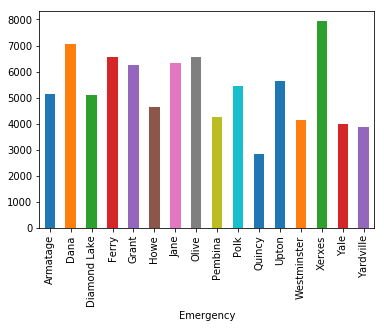

In [206]:
concat_dfs.groupby(['Emergency'])['Location'].count().plot(kind='bar')

In [207]:
concat_dfs.groupby(['Emergency', 'Day'])['Location'].count()

Emergency     Day
Armatage      2      2964
              3      2189
Dana          1       133
              2      4205
              3      2720
Diamond Lake  2      1025
              3      4063
Ferry         1       340
              2      3482
              3      2740
Grant         1       505
              2      3564
              3      2166
Howe          1       189
              2      2848
              3      1606
Jane          1       368
              2      3377
              3      2575
Olive         1       112
              2      3612
              3      2820
Pembina       1       190
              2      2769
              3      1308
Polk          1       244
              2      3367
              3      1824
Quincy        1       129
              2      2696
Upton         1       187
              2      2951
              3      2518
Westminster   1       157
              2      2536
              3      1458
Xerxes        1       189
              2     

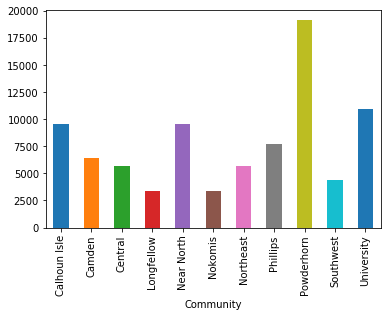

In [208]:
concat_dfs.groupby(['Community'])['Location'].count().plot(kind='bar')

In [215]:
all_tows_df = pd.read_csv(os.path.join(OUTPUT_DIR, "All_Tows.csv"))

# caught this error in community names -- fix it now and rewrite the .csv file.
all_tows_df.replace({'Calhoun Isles': 'Calhoun Isle'}, inplace=True)

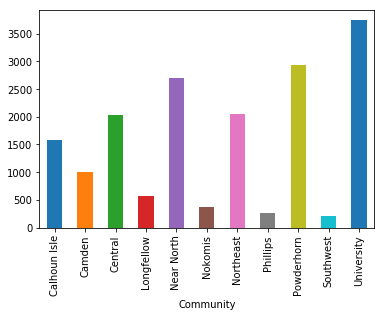

In [216]:
all_tows_df.groupby(['Community'])['Location'].count().plot(kind='bar')

In [217]:
all_tows_df.to_csv(os.path.join(OUTPUT_DIR, 'All_Tows.csv'))